# Summary of Time of Arrival Analysis
- final method uses method called iterate
    - default is three runs total, so two re-folds using best period each time
    - happy to help with any; e.g. saving best period from iterating on each source
    - cut-offs to use > 1 year
    - currently takes *mean* for final result
- organization could seem a little weird
    - first looking at sources with established periods from X-ray
    - and then the remaining sources in order
- method res is also important (looking at residuals) but is only used qualitatively
    - started analysis such as parabola but didn't seem useful/needed (e.g. pattern goes away with different number of bins)
- see corresponding table

In [18]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
from lmfit.models import GaussianModel
import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'
teal = '#439590'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') #most updated table from before Feb23 restart

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

srcns = np.array(alls['src_n'])
#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)
#simple plotting function
def plot(s,calib=False,both=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)
        
#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

In [19]:
#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

In [20]:
#preparation to start with objects with established period from X-ray

xlist = np.sort([7,12,31,37,11,13,6,27,2,3,12,44,49,56,60,9,23,36,54]) #list of sources (original source numbers) with X-ray-derived periods
#now with new source numbers, but fine to wait for translation until making a plot title
nxlist = []
for i in xlist: nxlist.append(src_dict[i])
xstr = [] #list of X-ray source numbers as strings
for x in xlist: xstr.append(str(x))
xdict = dict((k, []) for k in xstr) #will replace dictionary element with periods and stdevs

In [21]:
#loop through with different periods
src = 2
def toaloop(toas,start,end,step,src=src,title=True,color='black',label='',retbest=False,addtodict=True,plot=True,retstd=False):
    '''
    Loop through periods and plot the standard deviation of the decimal part of cycle numbers between ToAs
    toas: list or array of times of arrival
    start: starting period in loop
    src: 
        default is most recently defined src because of older version
        should be original source number and then src_dict used to get new one for plot title
    end: end period in loop
    step: stepsize in loop
    color: color of curve in plot
    label: label for curve (but legend must be called separately)
    retbest: return the best period within loop (period with lowest standard deviation)
    '''
    stds = []
    periods = np.arange(start,end,step)
    for p in periods:
        yax = toas - toas[0]
        #divide toa by period and round to nearest whole num
        xax = np.around(yax/p)
        #get difference between yax/p and nearest integer
        dec = yax/p - xax
        stds.append(np.nanstd(dec))
    if plot:
        plt.plot(periods,stds,color=color,label=label)
        #title with name, new source number
        if title:
            nsrcn = src_dict[src]
            name = name_dict[src]
            if len(str(name))>3: plt.title(f'{name} (Source #{nsrcn})',fontsize=14)
            else: plt.title(f'Source #{nsrcn}',fontsize=14)
        #axis labels
        plt.xlabel('Period (days)',fontsize=14)
        plt.ylabel(r'ToA $\sigma$',fontsize=14) #might want to be more precise at some point
    #if dictionary passed in
    if addtodict and 'xdict' in globals():
        #use most recently defined src
        key = str(int(src))
        xdict[key] = (periods,stds) #tuple of periods and stdevs
        print(f'added {src} to xdict')
    #return best period (one with lowest standard deviation)
    if retbest:
        bpind = np.where(stds==np.nanmin(stds))[0][0]
        bp = periods[bpind]
        if retstd:return stds,bp
        else: return bp

# Functions to Get ToAs
- fold with guess period and get time of maximum (optical minimum) for each or center using gaussian fit
- year function works for one year; year loop goes through all years of LC
    - maybe change to do by year clump rather than cutting off at years from start

In [22]:
def year(ib,p,n=1,mult=1,pbins=16,det=True,plotphase=False,minpoints=100,retref=False,gauss=False):
    '''
    Find TOA of maximum for the nth year of iband data
    --> now also requires that there are minpoints in that year (same start date, but extends if need be)
    ib: I band table, with or without detrended I mag
    p: initial period guess in days
    n: year of data (starting at 1)
    mult: multiples of year to include (e.g., 1 gives 1*365 days)
    pbins: number of phase bins
    det: whether or not to use spline-detrended data in phase-folding
    plotphase: for debugging mostly, plot the phase-folded data
    retref: return TOAs, reference time (necessary since not yearly 
            spacing once min points requirement)
    '''
    #if column of detrended not already there, detrend
    if 'I detrend' not in ib.columns: o.splinedetrend(ib)
    #add column of initial indices
    ib['ind'] = np.arange(len(ib))
    #first time in overall table
    t0 = ib['MJD-50000'][0]
    
    #make filtered table with just nth year
    y = ib[ib['MJD-50000']>t0+(n-1)*365*mult] #n for year number and mult for years/chunk
    if len(y)==0: return 'not enough left'
    #get first index

    init_ind = y['ind'][0]
    #upper bound
    y = y[y['MJD-50000']<t0+n*365*mult] #n for year number and mult for years/chunk

    #check that there are sufficient points
    if len(y)<minpoints:
        y = ib[init_ind:init_ind+minpoints]
    #new 0 time
    nt0 = float(y['MJD-50000'][0])

    #find reference time
    ref = nt0 #reference time beginning of current year
    
    #subtract reference time from all times in year table
    y['MJD-50000'] -= ref
    
    #phase-fold year of data
    mid,avg,err = o.meanphase(y,p,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
    #for debugging: plot phase
    if plotphase:
        plt.figure(figsize=(4,3))
        plt.step(mid,avg,where='mid',color='black')
        #add errors as one sigma
        plt.errorbar(mid,avg,yerr=err,color='black',marker='',linestyle='none',alpha=0.4)
        #flip y axis 
        maxa,mina = np.nanmax(avg),np.nanmin(avg)
        maxa += np.nanmax(err)
        mina -= np.nanmax(err)
        plt.ylim(maxa+.01,mina-.01)
    
    #find peak (min since in magnitudes)
    #using gaussian fit
    if gauss:
        x = mid[:16]
        imag = avg[:16]
        y = np.nanmax(imag) - imag 
        mod = GaussianModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x,nan_policy='omit')
        peakp = out.params['center'].value
    #using min
    else:
        peakp = mid[avg==np.nanmin(avg)][0] #phase loc of folded max
    maxday = p*peakp #peak in days (phase*period)
    #return time of arrival and reference time used
    if retref: return nt0+maxday,ref
    #return just toa
    return nt0+maxday

In [50]:
#newer version based on meeting notes from April 2021
def yearloop(src,p,mult=1,pbins=16,det=True,plotphase=False,findpd='no',minpoints=100,gauss=False,retpd=False):
    '''
    loop through all years of LC src
    arguments the same, but source number rather than iband given
    just return list of all ToAs
    
    src: original source number
    p: initial period guess in days
    mult: number of years to include 
    pbins: number of phase bins
    det: whether or not to use spline-detrended data in phase-folding
    plotphase: plot the phase-folded data (largely for debugging)
    findpd: period to use for guess
        if default and no nonzero guess passed in or 'best', overall best in 2-200d periodogram used
        if 'est,' Haberl established period used
    minpoints: minimum points for running for a given year
    gauss:
    retpd: 
        if True, returns ToAs and period used for guess
        if False, just returns ToAs
    '''
    #get iband LC
    try: iband = o.getIV(src,cross,stack=True,both=False,mlist=mlist1)
    except: iband = o.getIV(src,cross2,stack=True,both=False,mlist=mlist2)
    #if findpd not no, overwrite p with est. period or best auto det pd
    if findpd == 'est': p = float(summ[summ['src_n']==src]['est. period'])
    elif findpd == 'Coe': p = float(summ[summ['src_n']==src]['Coe est. period'])
    elif findpd == 'X-ray': p = float(summ[summ['src_n']==src]['X-ray period'])
    if findpd == 'best' or p == 0:p = float(summ[summ['src_n']==src]['best 2-200d period'])
    
    #find number of years of data
    time = iband['MJD-50000']
    nyr = int((time[-1]-time[0])/365)
    #list of TOAs 
    toas = []
    ref_times = []
    for i in range(1,nyr+1):
        rets = year(iband,p=p,n=i,mult=mult,pbins=pbins,det=det,plotphase=plotphase,minpoints=minpoints,retref=True,gauss=gauss)
        if rets == 'not enough left': break
        else: toas.append(rets[0]); ref_times.append(rets[1])
    
    #new version
    toas = np.array(toas)
    if retpd: return toas, p
    return toas   

In [51]:
#version of yearloop that identifies clumps instead of using # years since start of light curve
#add min points argument back in; use in sep_tables to combine when need be

def clumploop(src,p,mult=1,pbins=16,det=True,plotphase=False,findpd='no',retpd=False,plot_clumps=False,min_gap=50,minpoints=50):
    '''
    loop through all years of LC src
    arguments the same, but source number rather than iband given
    just return list of all ToAs
    
    src: original source number
    p: initial period guess in days
    mult: number of years to include 
    pbins: number of phase bins
    det: whether or not to use spline-detrended data in phase-folding
    plotphase: plot the phase-folded data (largely for debugging)
    findpd: period to use for guess
        if default and no nonzero guess passed in, best auto det period used
        if 'est,' established period used
        if 'best,' best auto det period used
    min_gap
    plot_clumps
    retpd: 
        if True, returns ToAs and period used for guess
        if False, just returns ToAs
    '''
    #get list of separate iband LC clumps to work with
    try:sep_tables = o.separate_clumps(src,cross,mlist1,min_gap=min_gap,plot=plot_clumps,minpoints=minpoints)
    except:sep_tables = o.separate_clumps(src,cross2,mlist2,min_gap=min_gap,plot=plot_clumps,minpoints=minpoints)

    if findpd == 'est': p = float(summ[summ['src_n']==src]['est. period'])
    elif findpd == 'Coe': p = float(summ[summ['src_n']==src]['Coe est. period'])
    elif findpd == 'X-ray': p = float(summ[summ['src_n']==src]['X-ray period'])
    if findpd == 'best' or p == 0:p = float(summ[summ['src_n']==src]['best 2-200d period'])
    
    #first overall time
    t0 = sep_tables[0]['MJD-50000'][0]
    
    #list of TOAs 
    toas = []
    ref_times = []
    for i in range(len(sep_tables)-1):
        current_clump = sep_tables[i]
        #new 0 time
        nt0 = float(current_clump['MJD-50000'][0])
        #find reference time
        ref = nt0 #reference time beginning of current year
        #subtract start of clump from all times in clump
        current_clump['MJD-50000'] -= ref
        
        #phase-fold clump of data
        mid,avg,err = o.meanphase(current_clump,p,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
        
        peakp = mid[avg==np.nanmin(avg)][0] #phase loc of folded max brightness
        maxday = p*peakp #peak in days (phase*period)
        #return time of arrival and reference time used
        toas.append(nt0+maxday)
        ref_times.append(ref)
    
    #new version
    toas = np.array(toas)
    if retpd: return toas, p
    return toas   

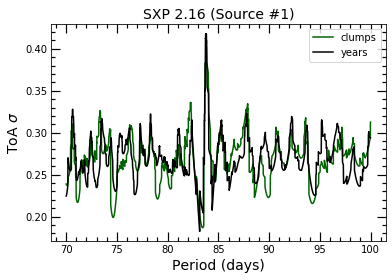

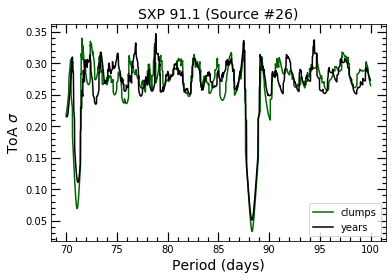

In [25]:
#examples comparing separation by clump and separation by year
#main sensitivity with clump may revolve around the way it deals with minpoints

#if we change to minpoints 50 here clump method noisier with current methods
src = 2
toas_clump = clumploop(src,0,findpd='est',minpoints=30)
toas = yearloop(src,0,findpd='est',minpoints=30)
toaloop(toas_clump,70,100,0.001,src=src,color='darkgreen',addtodict=False,label='clumps')
toaloop(toas,70,100,0.01,src=src,addtodict=False,label='years')
plt.legend()
plt.show()

#clump loop example compared to yearloop
#but (both?) sensitive to minpoints
#clumps esp. sensitive since it then just combines everything

toas_clump = clumploop(28,0,findpd='est',minpoints=30)
toas = yearloop(28,0,findpd='est',gauss=False,minpoints=30)
toaloop(toas_clump,70,100,0.001,src=28,color='darkgreen',addtodict=False,label='clumps')
toaloop(toas,70,100,0.01,src=28,addtodict=False,label='years')
plt.legend()

added 28 to xdict


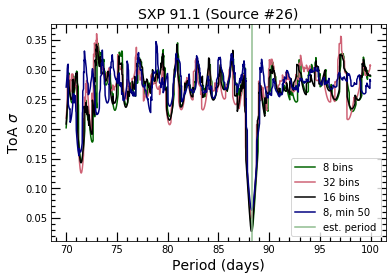

In [26]:
#sensitivity to min points and phase bins

src = 28
toas = yearloop(28,0,findpd='est',gauss=False,minpoints=30)
toas32 = yearloop(src,0,pbins=32,findpd='est',gauss=False)
toas8 = yearloop(src,0,pbins=8,findpd='est',gauss=False)
#trying different min points
toas_min50 = yearloop(src,0,pbins=8,findpd='est',gauss=False,minpoints=50)
toas_min200 = yearloop(src,0,pbins=8,findpd='est',gauss=False,minpoints=200)
toas = yearloop(src,89,findpd='no',gauss=False)

#illustrating effect of different numbers of phase bins
toaloop(toas8,70,100,0.0001,src=28,color='darkgreen',label='8 bins',addtodict=False)
toaloop(toas32,70,100,0.01,src=28,color=pink,label='32 bins')
toaloop(toas,70,100,0.01,src=28,label='16 bins',addtodict=False)
toaloop(toas_min50,70,100,0.01,src=28,label='8, min 50',color='navy',addtodict=False)
# toaloop(toas_min200,70,100,0.01,label='8, min 200',color='goldenrod') #not as good

plt.axvline(88.34,color='darkseagreen',label='est. period')
plt.legend()

In [27]:
def res(toas,pd,retfit=False,order=1,line=False,src=src,save=True):
    '''
    Calculate and plot residuals of time of arrival for given period as a function of cycle
    '''
    xax = np.around((toas - toas[0])/pd)
    yax = toas - toas[0]
    fit = np.polyfit(xax,yax,order)
    if order==1:eqn = xax*fit[0]+fit[1]
    else: eqn = fit[0]*xax**2+xax*fit[1]+fit[2] #only works for quadratic currently
    #divide by period to be in terms of phase
    res = yax - eqn
    res /= pd
    fig,(ax,ax1) = plt.subplots(1,2,figsize=(12,4))
    ax.scatter(xax,yax,color='black',label=f'P:{pd:.2f}')
    if order==1: label = f'slope: {fit[0]:.2f}'
    else: label = f'P:{fit[1]:.2f}, Pdot:{fit[0]:.2f}'
    ax.plot(xax,eqn,color=pink,label=label)
    ax.set_ylabel(r'ToAs $-$ first ToA',fontsize=14)
    ax.set_xlabel('Rounded Cycle #',fontsize=14)
    ax1.set_xlabel('Rounded Cycle #',fontsize=14)
    ax1.scatter(xax,res,color='black')
    if line: ax1.plot(xax,res,color='grey')
    ax1.set_ylabel('Residuals/Pd',fontsize=14)
    ax.legend()
    #add title
    nsrcn = src_dict[src]
    name = name_dict[src]
    if len(str(name))>3: fig.suptitle(f'{name} (Source #{nsrcn})',fontsize=14)
    else: fig.suptitle(f'Source #{nsrcn}',fontsize=14)    
    plt.subplots_adjust(wspace=0.2)
    if save: plt.savefig(f'ToAFigsFeb23/src{nsrcn}_{src}_ToA_residuals.pdf',bbox_inches='tight')
    plt.show()
    if retfit: return fit

In [ ]:
#main code used for the rest of the notebook: can iterate more than once with re-folding
def iterate(src,num=3,step=0.01,plot=True,det=True,usep=0,save=True,addtodict=True):
    row = summ[summ['src_n']==src].iloc[0]
    #"Haberl" period
    haberl = row['est. period']
    #Coe period
    coe = row['Coe est. period']
    if np.isnan(coe): coe = 0
    #X-ray period
    xray = row['X-ray period']
    if np.isnan(xray): xray = 0
    #best 2-200d
    best = row['best 2-200d period']
    #best near Haberl
    near_haberl = row['best auto det pd']
    #best near Coe
    near_coe = row['best near Coe']

    if haberl>100 or coe>100 or best>100 or near_haberl>100 or near_coe>100: mult=2
    elif haberl>200 or coe>200 or best>200 or near_haberl>200 or near_coe>200: mult=3
    else:mult=1
    
    #search within a tenth of est. periods
    all_periods = np.array([haberl,near_haberl,coe,near_coe,xray,best])
    nonzero_periods = all_periods[np.nonzero(all_periods)]
    min_est = np.min(nonzero_periods)
    max_est = np.max(nonzero_periods)
    search_min = min_est - min_est/10
    search_max = max_est + max_est/10
    
    periods = np.arange(search_min,search_max,step)
    allstds = np.zeros((num,len(periods)))
    
    #find toas; always just starts with overall periodgram best...
    toas,pd = yearloop(src,best,mult=mult,findpd='no',retpd=True,det=det)
    stds,minp = toaloop(toas,search_min,search_max,step,src=src,color='black',retbest=True,plot=False,retstd=True)
    allstds[0] = stds
    for i in range(num-1): #refolding/iterating
        toas,pd = yearloop(src,minp,mult=mult,findpd='no',retpd=True)
        stds,minp = toaloop(toas,search_min,search_max,step,src=src,color='black',retbest=True,plot=False,retstd=True,addtodict=addtodict)
        allstds[i+1] = stds
    #average and plot the result
    mstd = np.mean(allstds,axis=0)
    if plot:
        plt.figure(figsize=(7,4))
        plt.plot(periods,mstd,color='black')
        
        #Xray period
        if xray>0:plt.axvline(xray,color='#4B5A6C',alpha=0.4,ls='dotted',label=f'X-ray pd {xray:.2f}')
        if haberl>0:
            plt.axvline(haberl,color='darkseagreen',alpha=0.4,label=f'Haberl pd {haberl:.2f}')
            if near_haberl!=best:plt.axvline(near_haberl,color='darkseagreen',alpha=0.4,ls='dashdot',label=f'pdgram best near Haberl {near_haberl:.2f}')
        if coe>0:
            plt.axvline(coe,color='maroon',ls='dashed',alpha=0.4,label=f'Coe pd {coe:.2f}')
            if near_coe!=near_haberl and near_coe!=best:plt.axvline(near_coe,color='maroon',alpha=0.4,ls='dashdot',label=f'nearby pdgram best {near_coe:.2f}')
        plt.axvline(best,ls=(0, (5, 1)),color='#554971',label=f'pdgram best {best:.2f}')
        
        plt.legend(fontsize=10,bbox_to_anchor=(1.005, 1.02))
        nsrcn = src_dict[src]
        name = name_dict[src]
        if len(str(name))>3: plt.title(f'{name} (Source #{nsrcn})',fontsize=14)
        else: plt.title(f'Source #{nsrcn}',fontsize=14)
        #axis labels
        plt.xlabel('Period (days)',fontsize=14)
        plt.ylabel(r'ToA $\sigma$',fontsize=14) #might want to be more precise at some point
        if save: plt.savefig(f'ToAFigsFeb23/src{nsrcn}_{src}_ToA.pdf',bbox_inches='tight')
    #identify final best period
    bpind = np.where(mstd==np.nanmin(mstd))[0][0]
    bp = periods[bpind]
    return bp

# Analyze Sources with Est. From X-ray

xlist = [7,12,31,37,11,13,6,27,2,3,12,44,49,56,60,9,23,36,54,24]

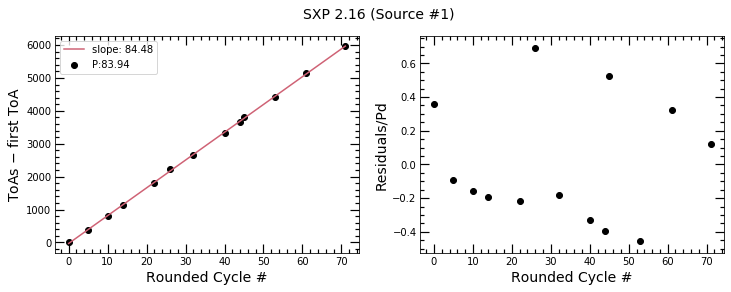

added 2 to xdict
added 2 to xdict
added 2 to xdict


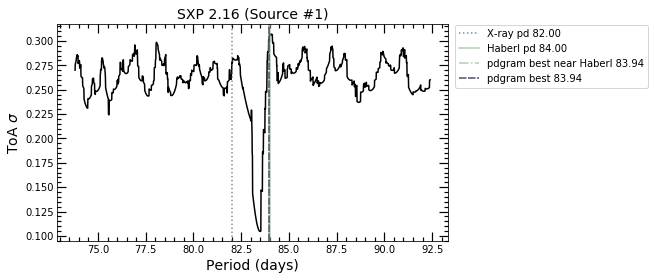

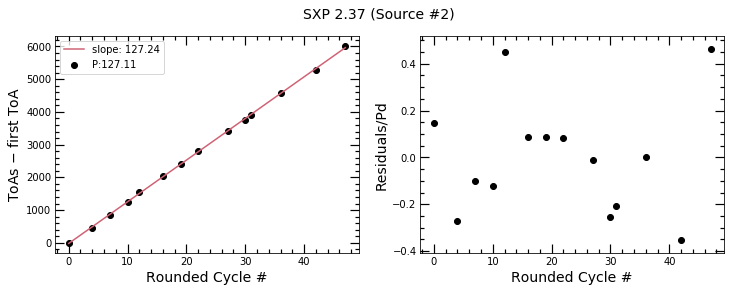

added 3 to xdict
added 3 to xdict
added 3 to xdict


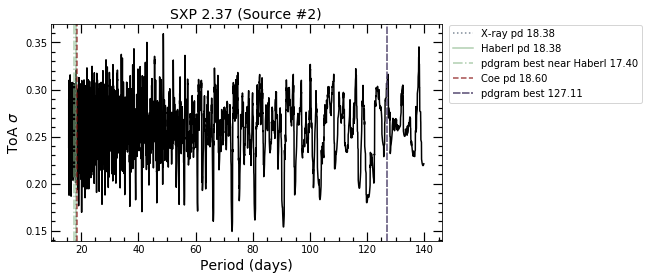

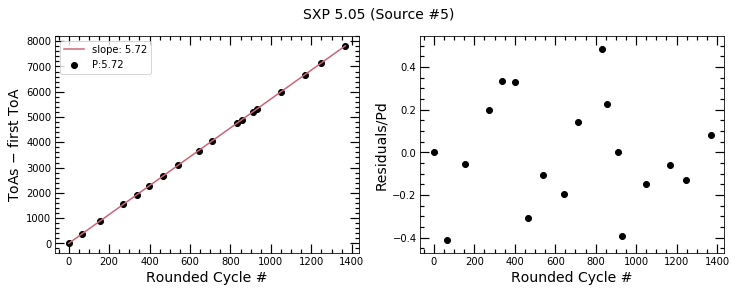

added 6 to xdict
added 6 to xdict
added 6 to xdict


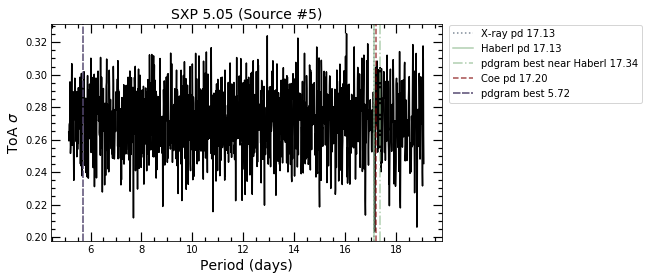

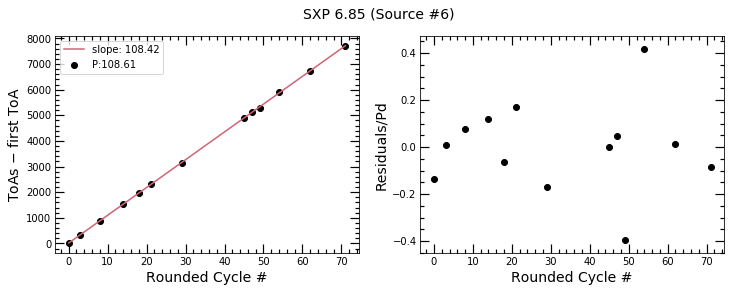

added 7 to xdict
added 7 to xdict
added 7 to xdict


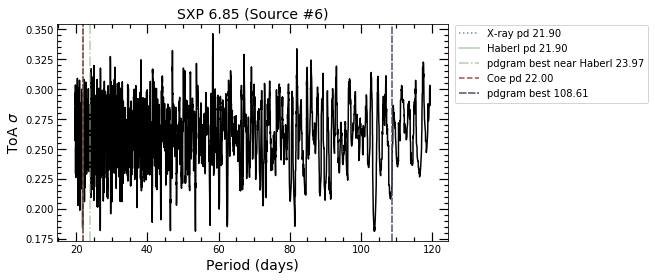

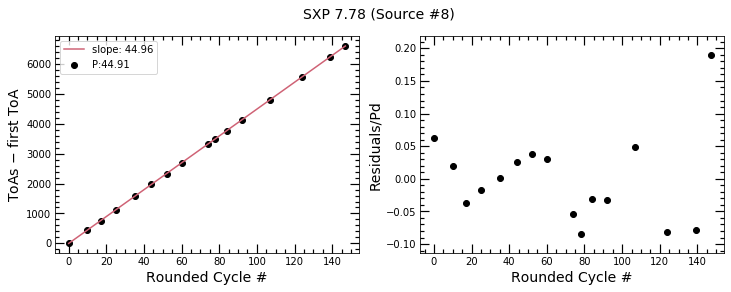

added 9 to xdict
added 9 to xdict
added 9 to xdict


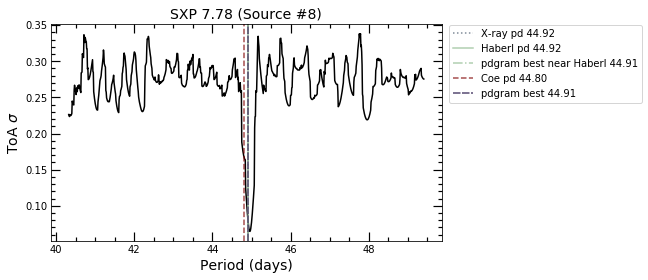

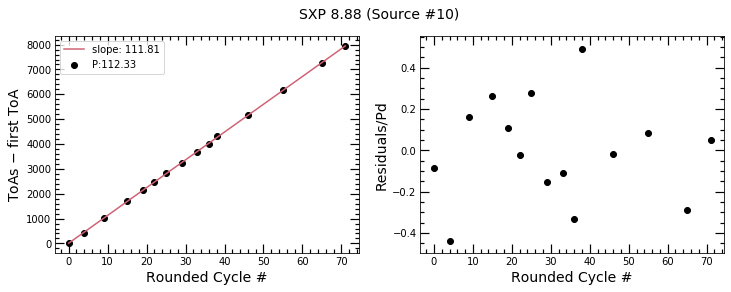

added 11 to xdict
added 11 to xdict
added 11 to xdict


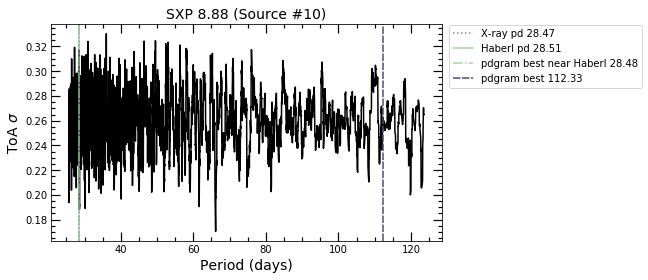

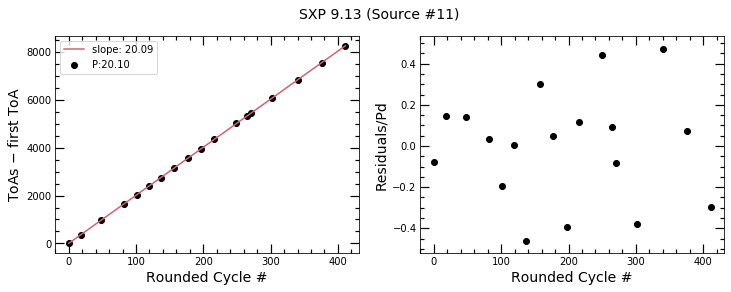

added 12 to xdict
added 12 to xdict
added 12 to xdict


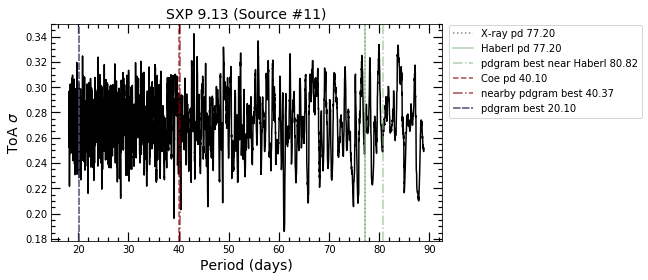

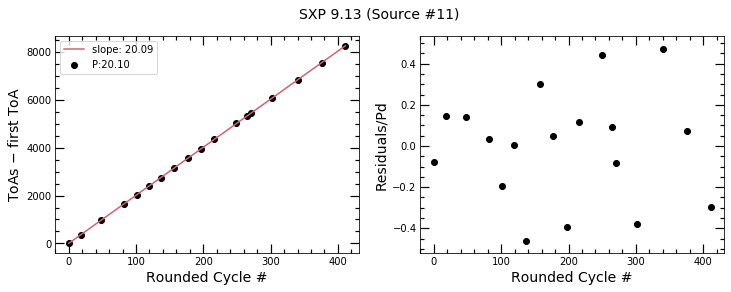

added 12 to xdict
added 12 to xdict
added 12 to xdict


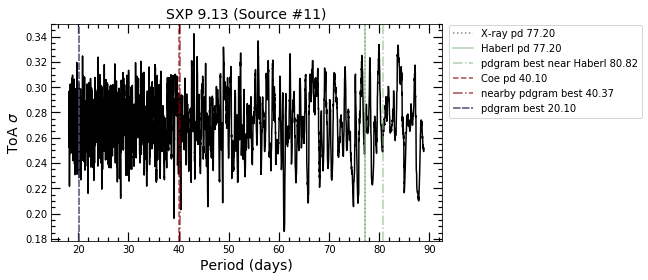

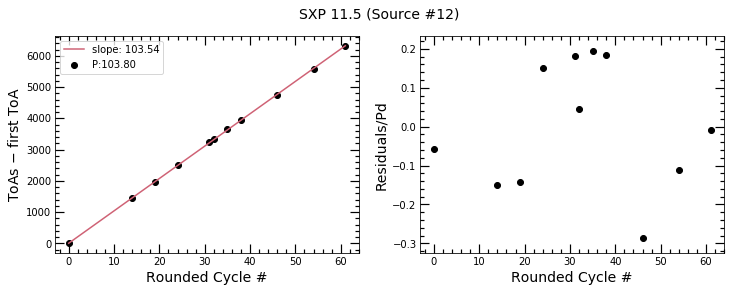

added 13 to xdict
added 13 to xdict
added 13 to xdict


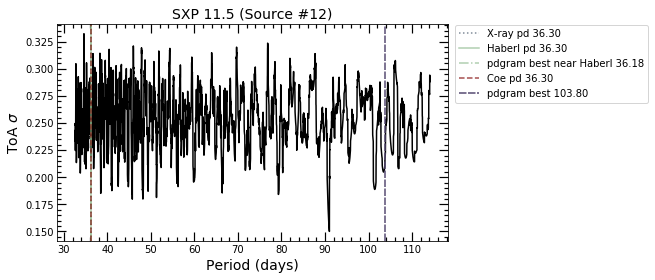

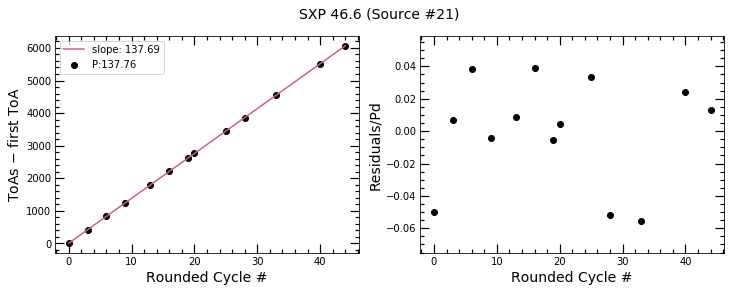

added 23 to xdict
added 23 to xdict
added 23 to xdict


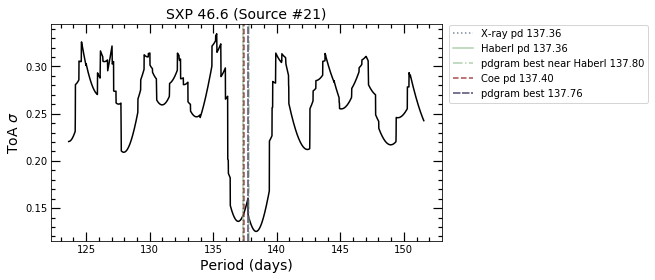

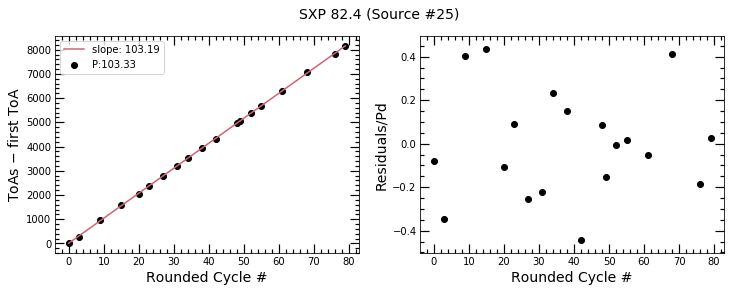

added 27 to xdict
added 27 to xdict
added 27 to xdict


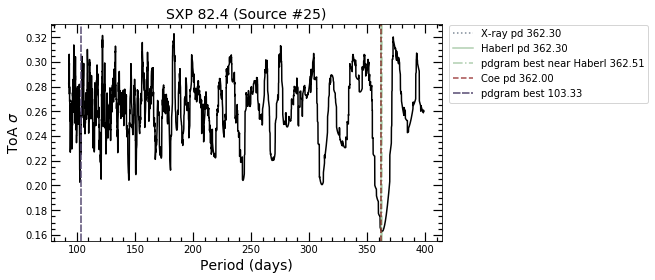

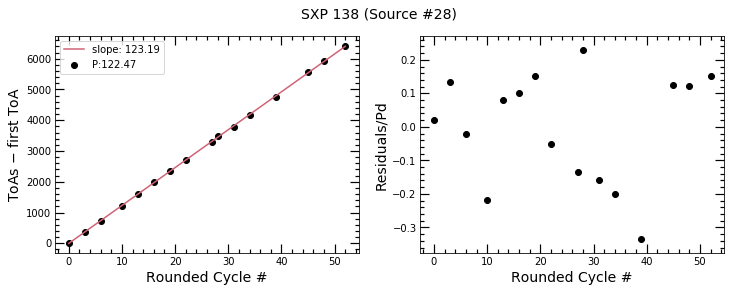

added 31 to xdict
added 31 to xdict
added 31 to xdict


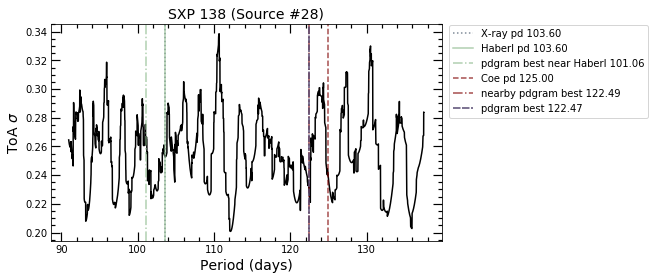

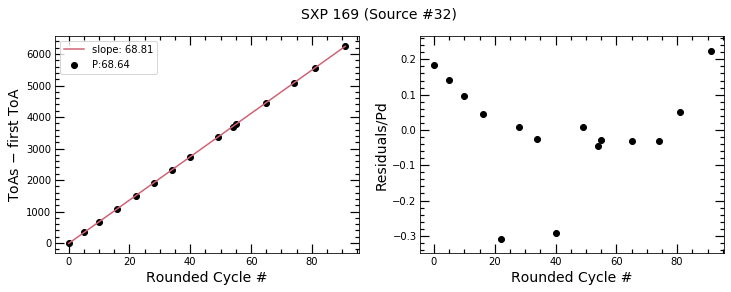

added 36 to xdict
added 36 to xdict
added 36 to xdict


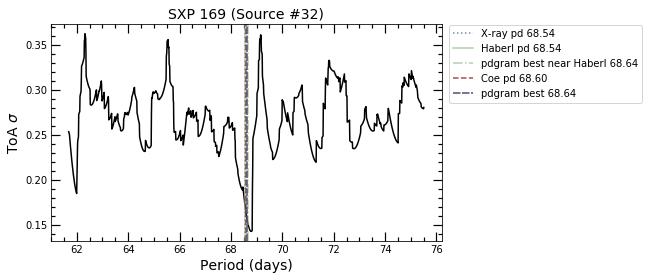

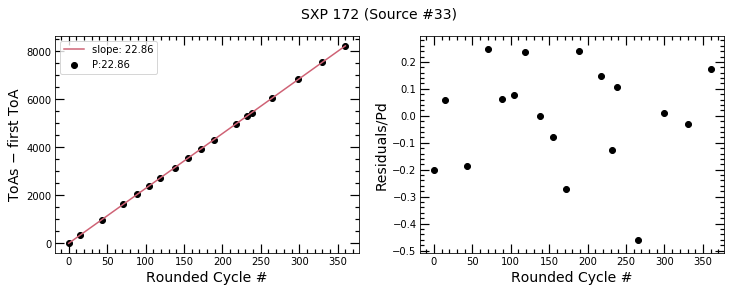

added 37 to xdict
added 37 to xdict
added 37 to xdict


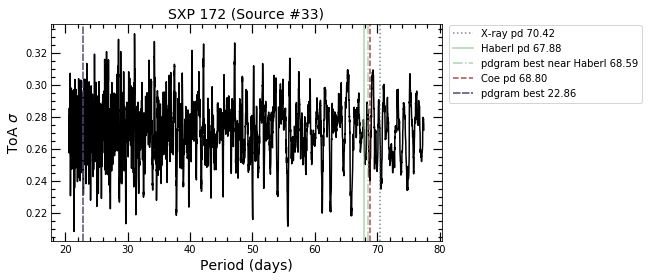

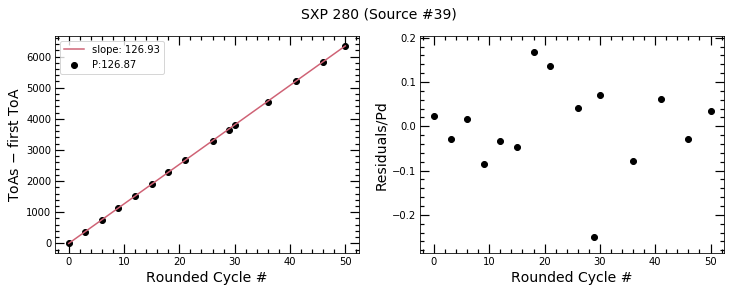

added 44 to xdict
added 44 to xdict
added 44 to xdict


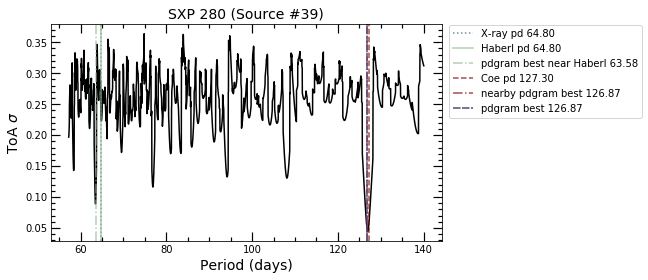

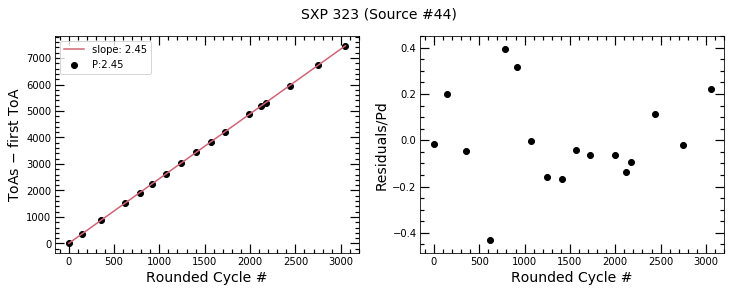

added 49 to xdict
added 49 to xdict
added 49 to xdict


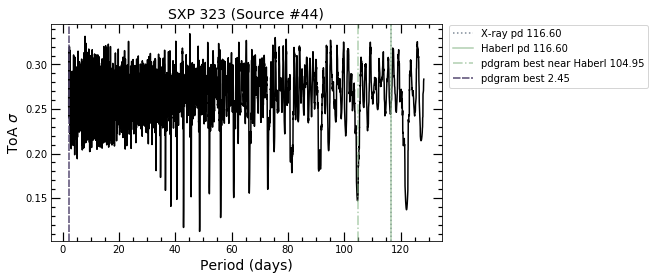

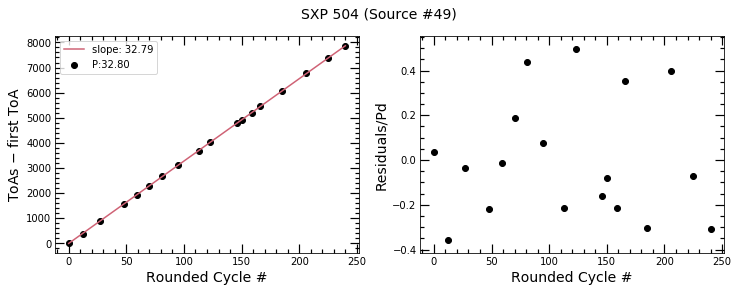

added 54 to xdict
added 54 to xdict
added 54 to xdict


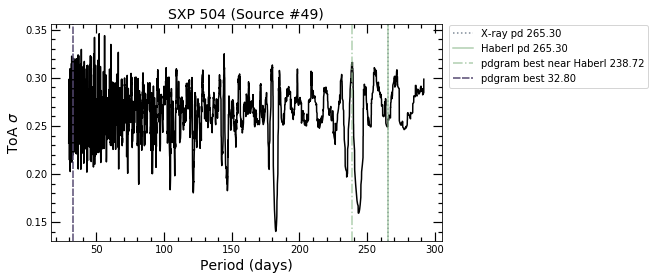

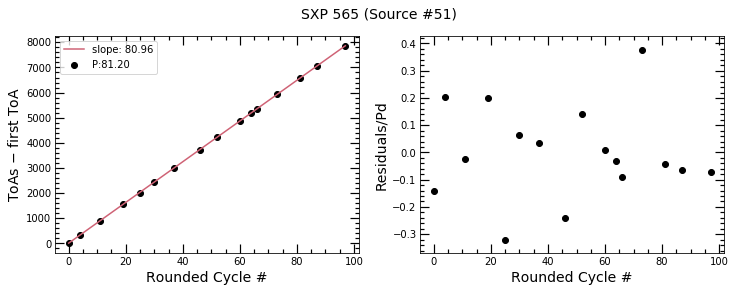

added 56 to xdict
added 56 to xdict
added 56 to xdict


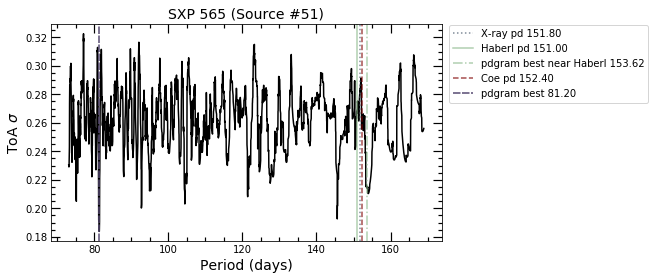

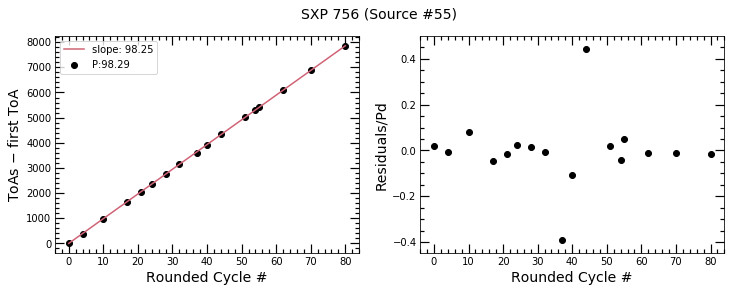

added 60 to xdict
added 60 to xdict
added 60 to xdict


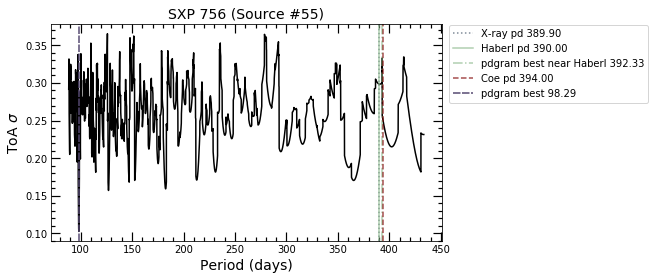

In [73]:
for i in range(len(xlist)):
    src = xlist[i]
    #starts with best from 2-200d periodogram
    toas,pd = yearloop(src,0,findpd='best',retpd=True)
    res(toas,pd,src=src)
    iterate(src)

## summary of results from sources with established from X-ray
- will have to fix (and write out new npz) since a couple results different b/c mult arg fixed

In [75]:
#for this figure, just get X-ray periods and periodogram bests
xray_periods = []
pdgram_periods = []
for x in xlist:
    row = summ[summ['src_n']==x]
    xray = float(row['X-ray period'])
    if xray>200:
        best = float(row['best auto det pd'])
    else:best = float(row['best 2-200d period'])
    xray_periods.append(xray)
    pdgram_periods.append(best)

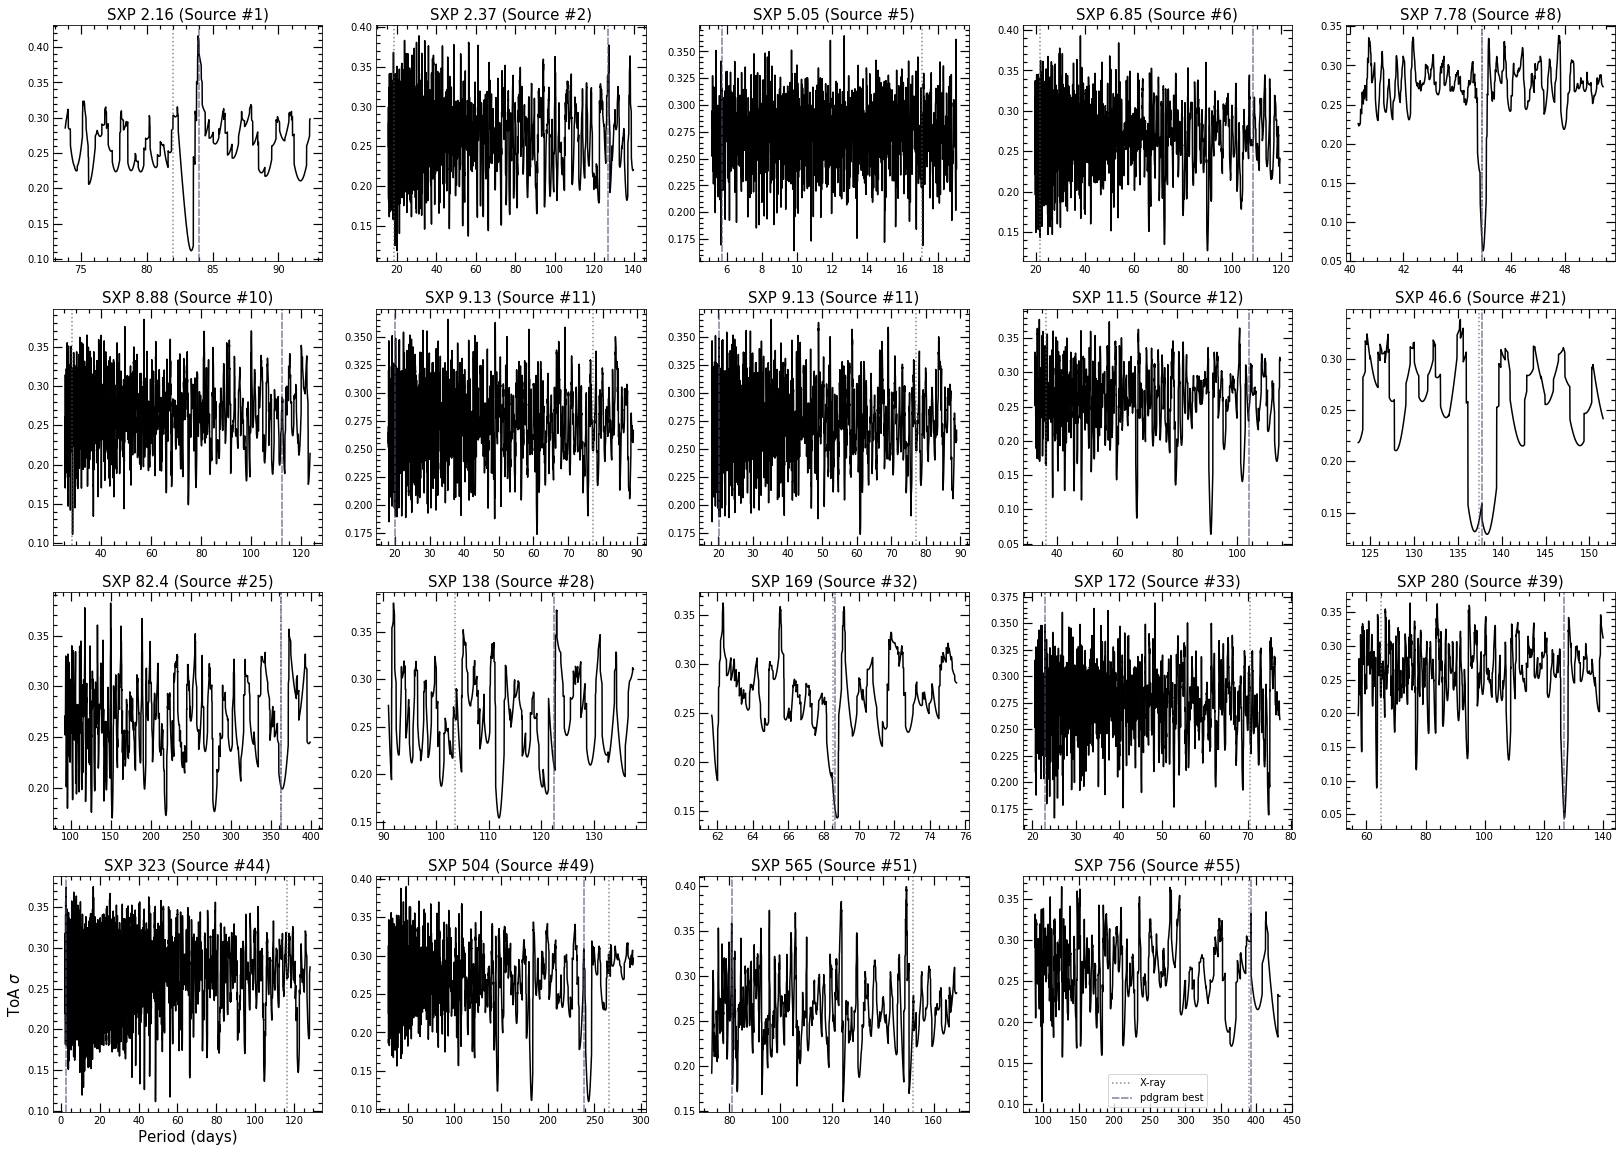

In [78]:
fig = plt.figure(figsize=(28,20))
c = 1
for x in xlist:
    src = str(int(x))
    periods = xdict[src][0]
    stds = xdict[src][1]
    ax = fig.add_subplot(4,5,c)
    best = pdgram_periods[c-1]
    xray = xray_periods[c-1]
    ax.plot(periods,stds,color='black')
    ax.axvline(xray,color='#4B5A6C',label='X-ray',alpha=0.7,ls='dotted')
    ax.axvline(best,ls=(0, (5, 1)),color='#554971',alpha=0.7,label='pdgram best')
    nsrcn = src_dict[int(src)]
    name = name_dict[int(src)]
    if len(str(name))>3: ax.set_title(f'{name} (Source #{nsrcn})',fontsize=15)
    else: ax.set_title(f'Source #{nsrcn}',fontsize=15)
    if x==xlist[-1]: ax.legend()
    if x==xlist[15]:
        ax.set_ylabel(r'ToA $\sigma$',fontsize=15)
        ax.set_xlabel('Period (days)',fontsize=15)
    c+=1
sf('Feb23_XrayToA')

In [77]:
np.savez('Feb23_XrayToAs', xdict)

# Analyze ToAs for Remaining Sources, Looking out for Interesting Sources from PeriodbyYear Notebook


empty file for OIII I
1 not working...


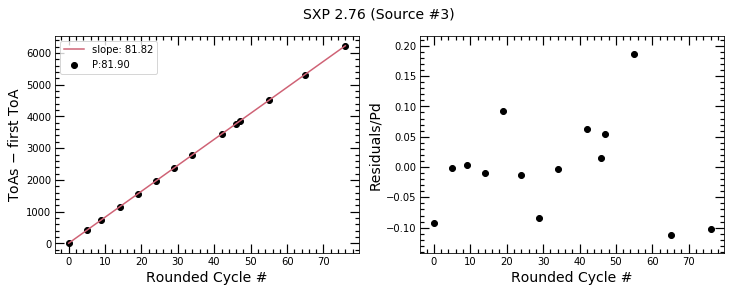

added 4 to xdict
added 4 to xdict
added 4 to xdict


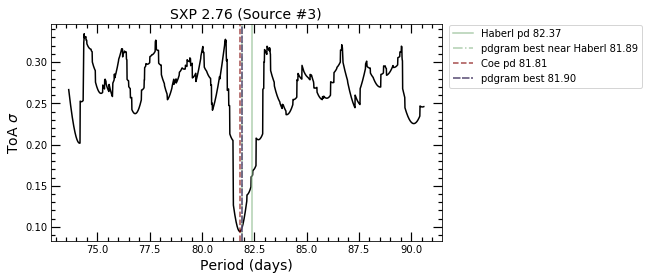

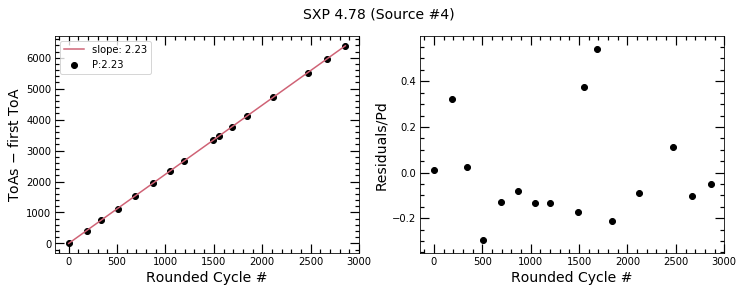

added 5 to xdict
added 5 to xdict
added 5 to xdict


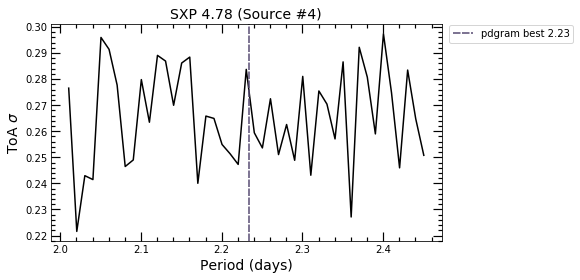

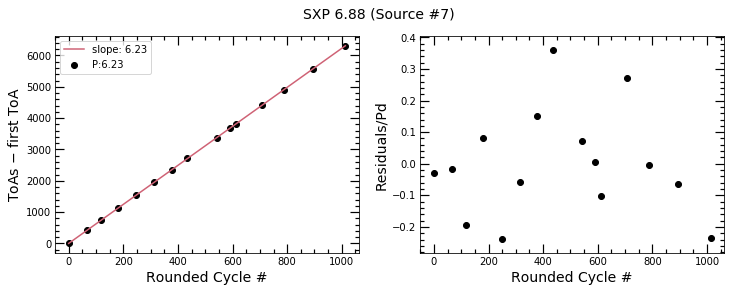

added 8 to xdict
added 8 to xdict
added 8 to xdict


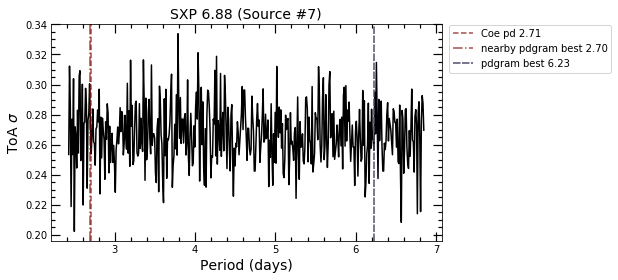

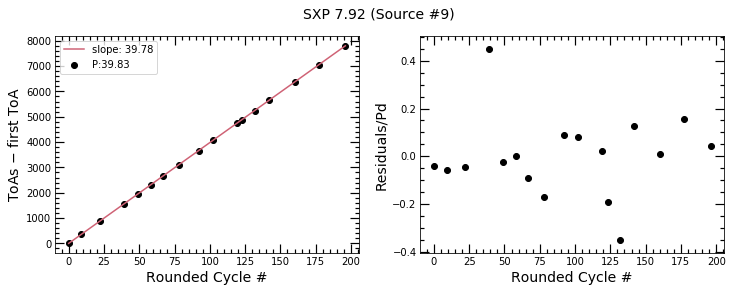

added 10 to xdict
added 10 to xdict
added 10 to xdict


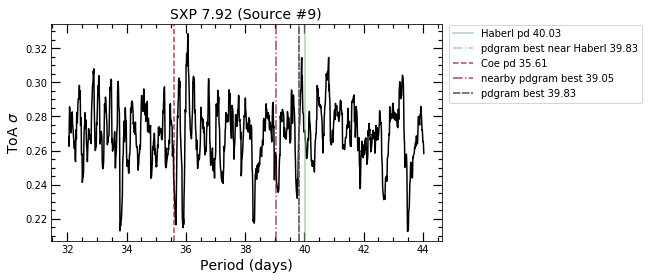

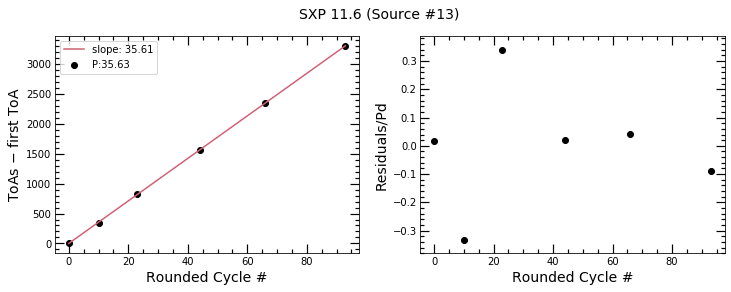

added 14 to xdict
added 14 to xdict
added 14 to xdict


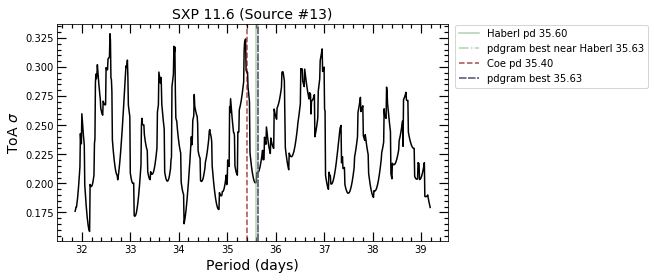

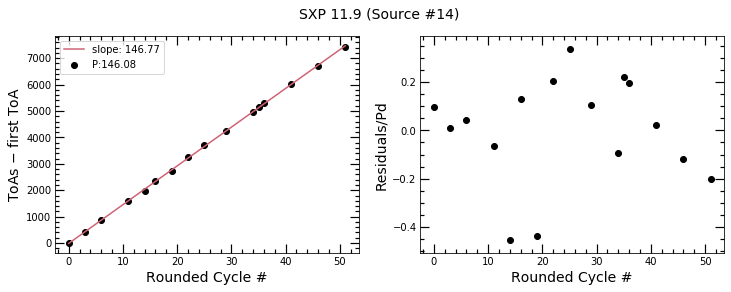

added 15 to xdict
added 15 to xdict
added 15 to xdict


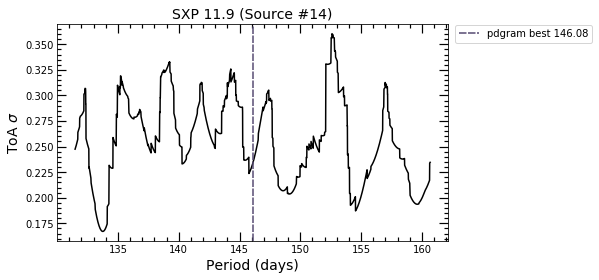

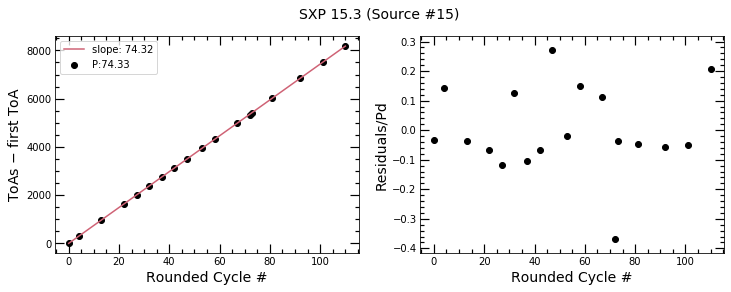

added 16 to xdict
added 16 to xdict
added 16 to xdict


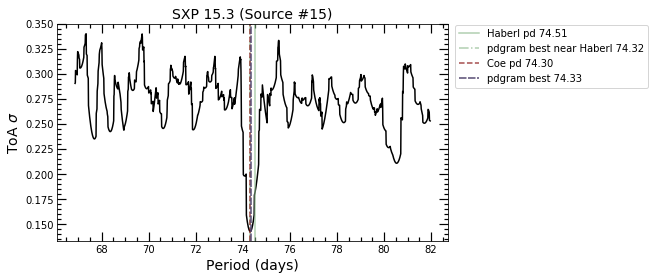

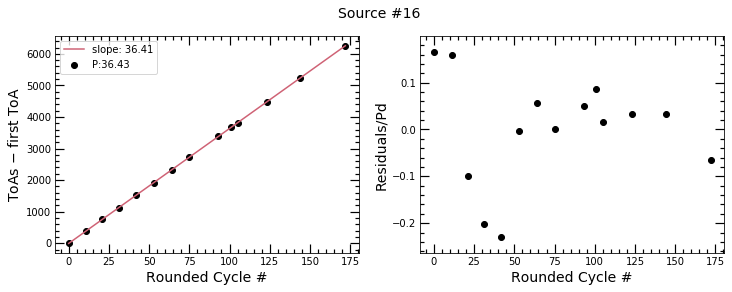

added 17 to xdict
added 17 to xdict
added 17 to xdict


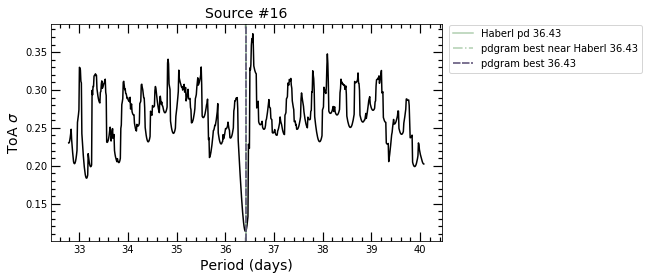

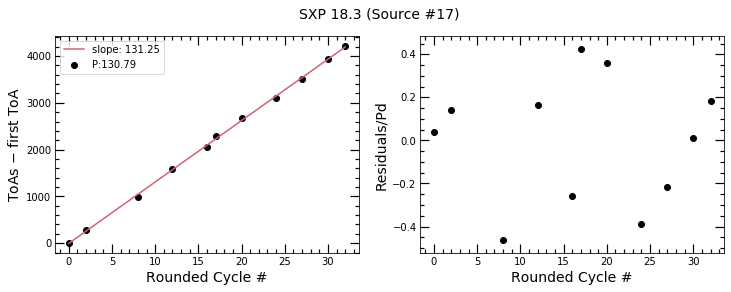

added 19 to xdict
added 19 to xdict
added 19 to xdict


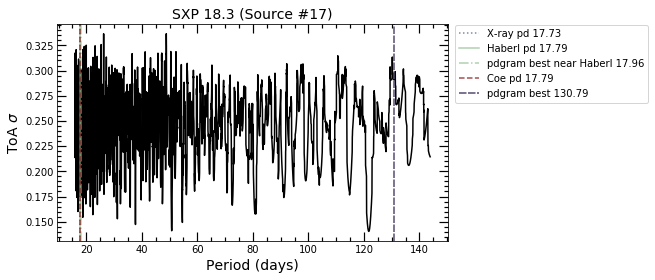

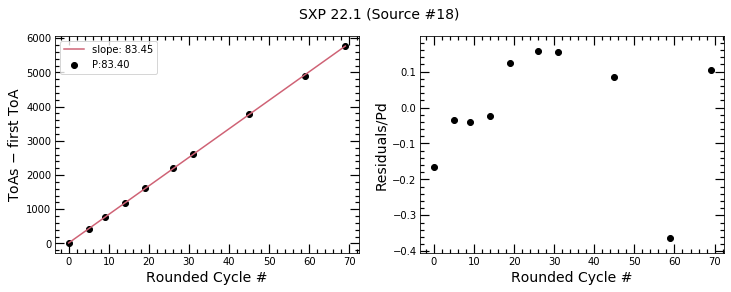

added 20 to xdict
added 20 to xdict
added 20 to xdict


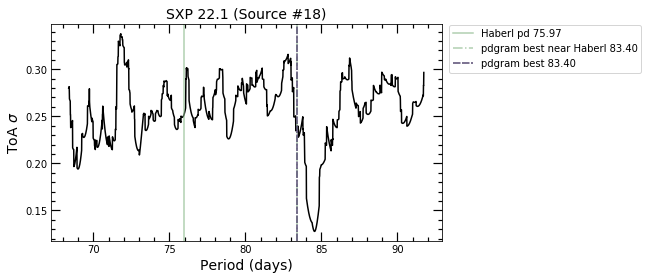

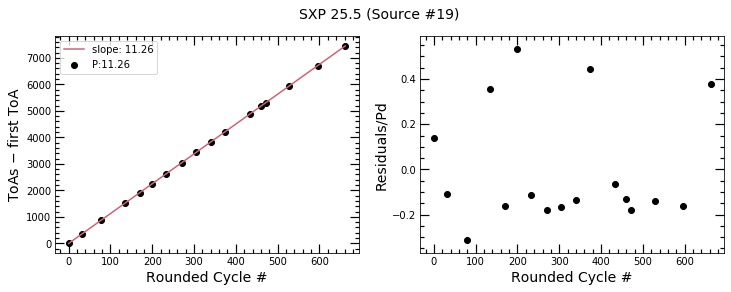

added 21 to xdict
added 21 to xdict
added 21 to xdict


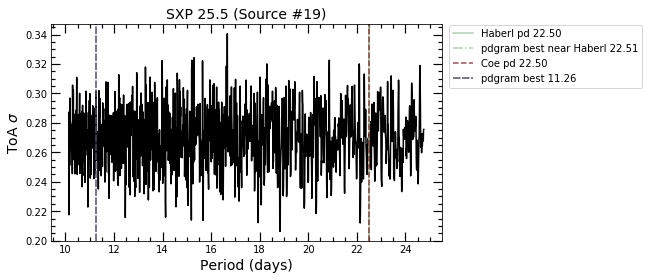

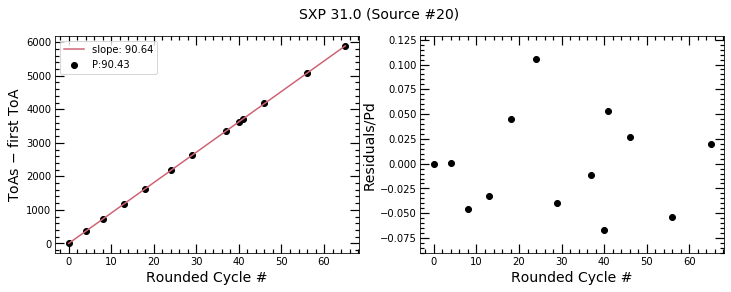

added 22 to xdict
added 22 to xdict
added 22 to xdict


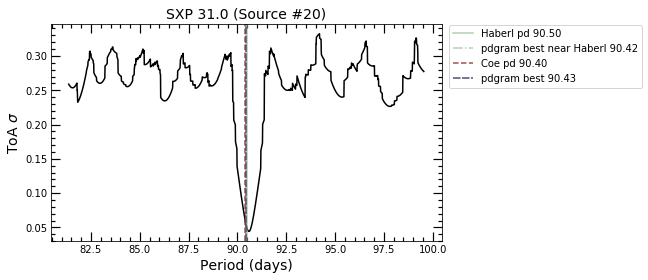

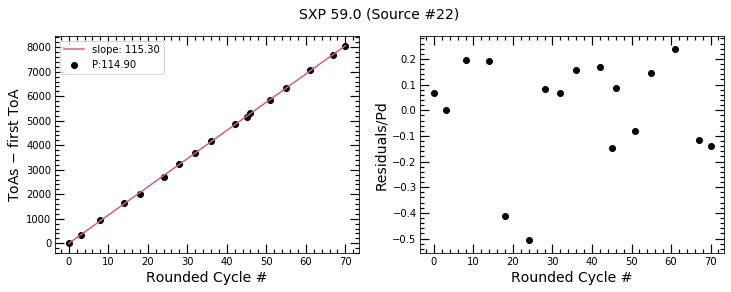

added 24 to xdict
added 24 to xdict
added 24 to xdict
empty file for OIII I


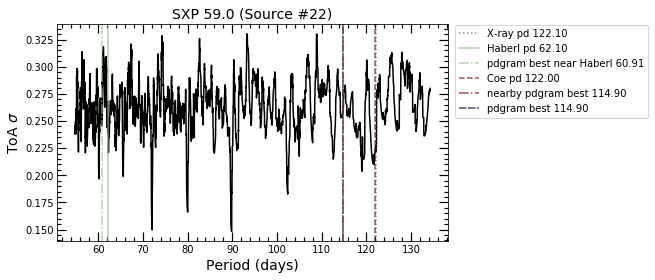

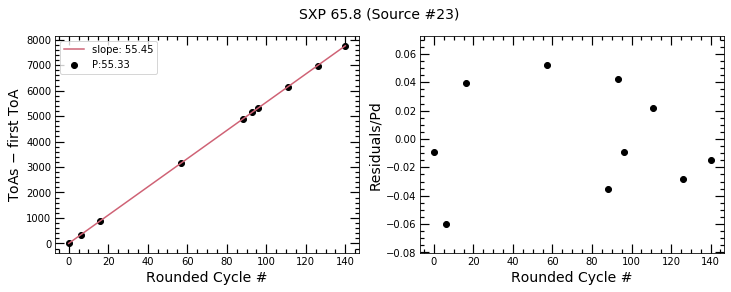

empty file for OIII I
added 25 to xdict
empty file for OIII I
added 25 to xdict
empty file for OIII I
added 25 to xdict


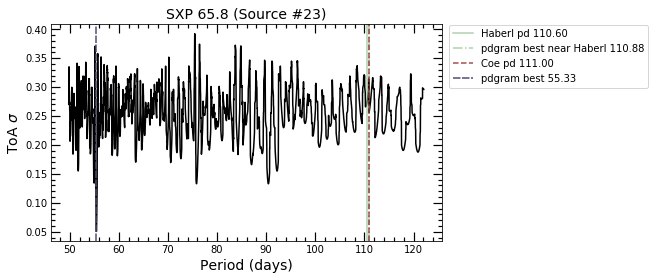

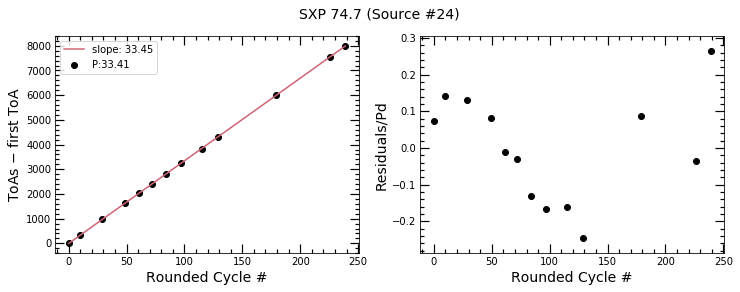

added 26 to xdict
added 26 to xdict
added 26 to xdict


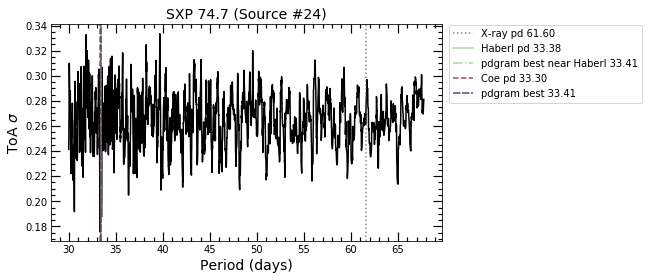

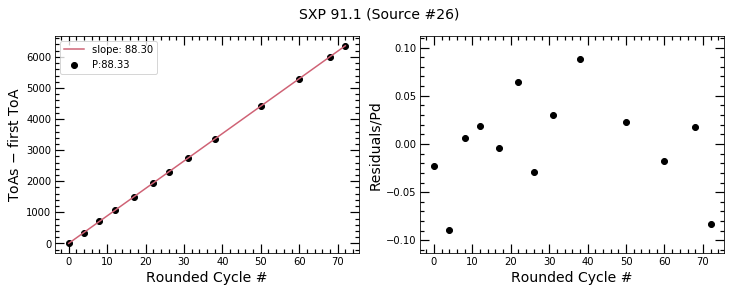

added 28 to xdict
added 28 to xdict
added 28 to xdict


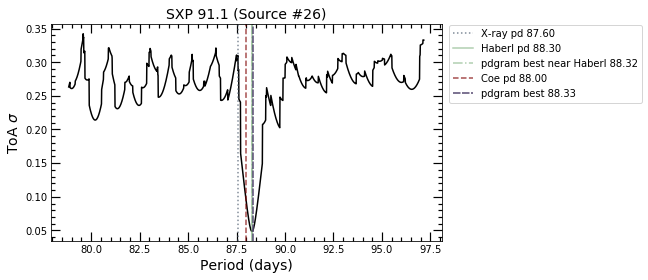

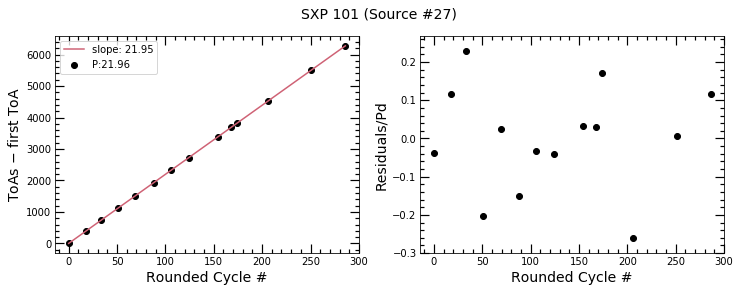

added 30 to xdict
added 30 to xdict
added 30 to xdict
32 not working...


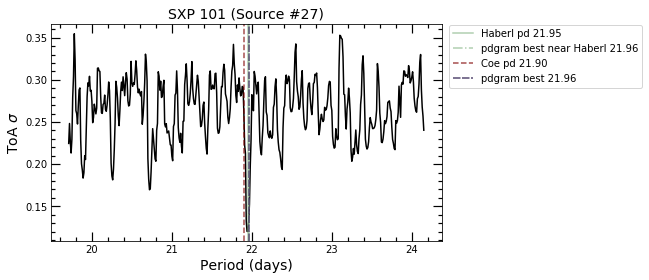

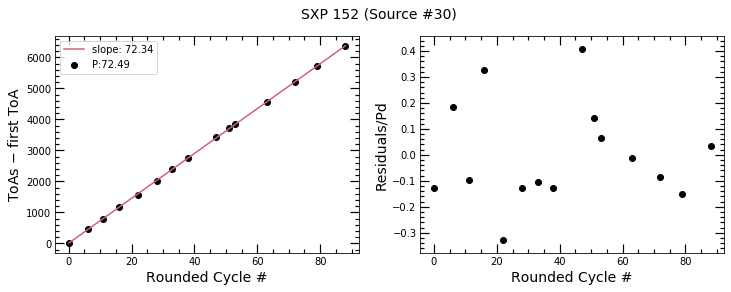

added 34 to xdict
added 34 to xdict
added 34 to xdict


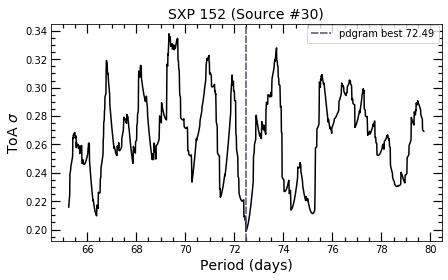

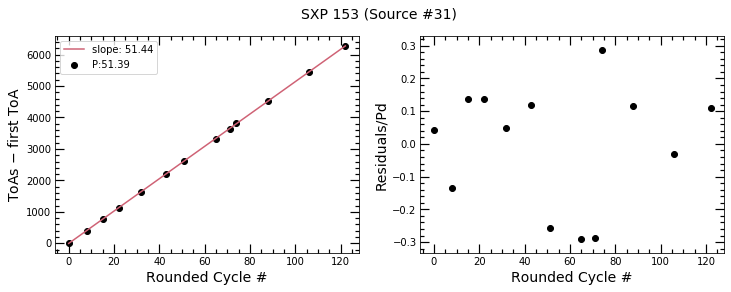

added 35 to xdict
added 35 to xdict
added 35 to xdict


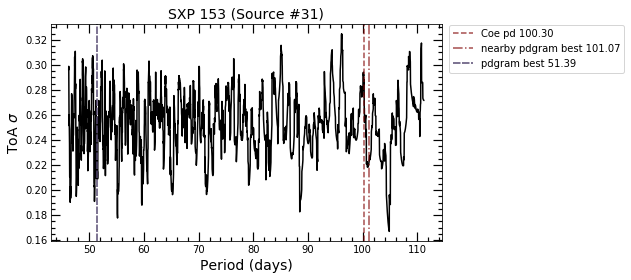

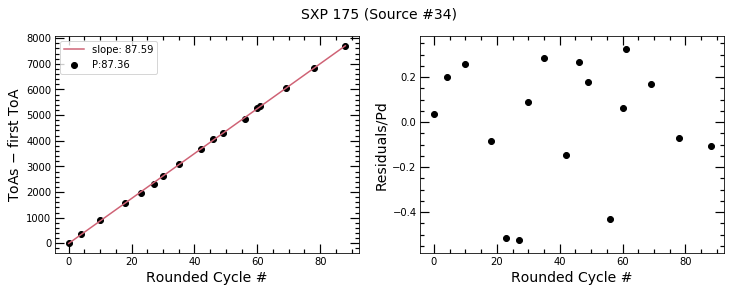

added 38 to xdict
added 38 to xdict
added 38 to xdict


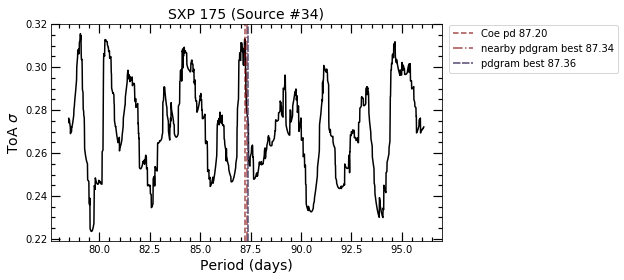

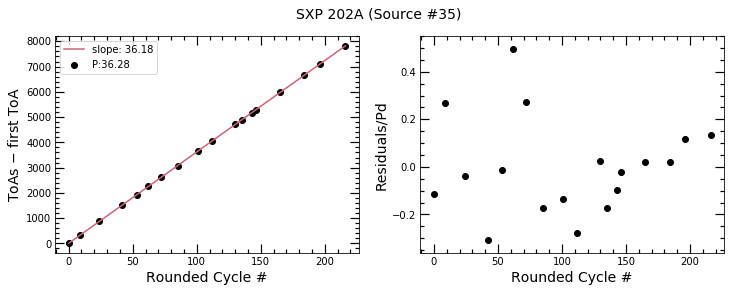

added 39 to xdict
added 39 to xdict
added 39 to xdict


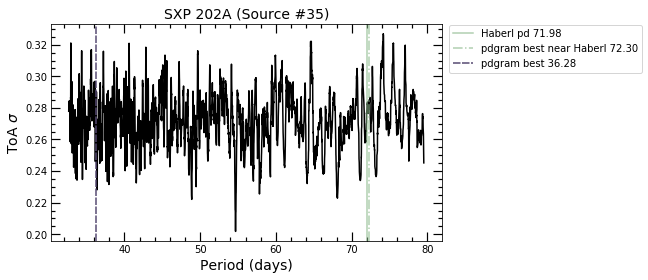

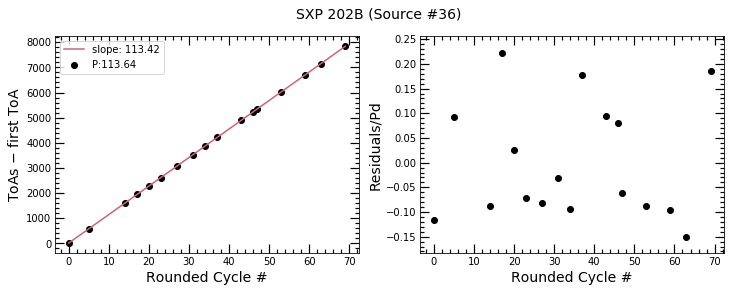

added 40 to xdict
added 40 to xdict
added 40 to xdict


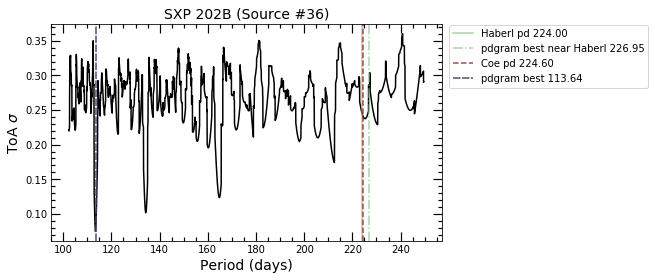

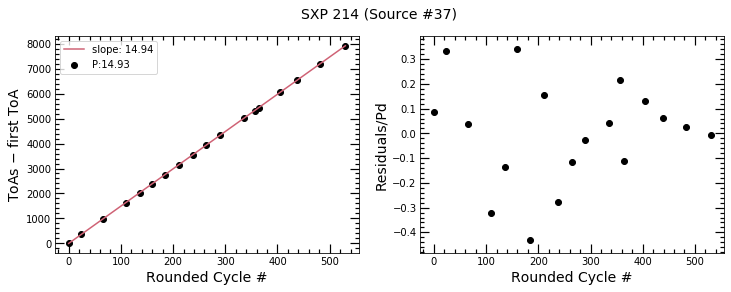

added 41 to xdict
added 41 to xdict
added 41 to xdict


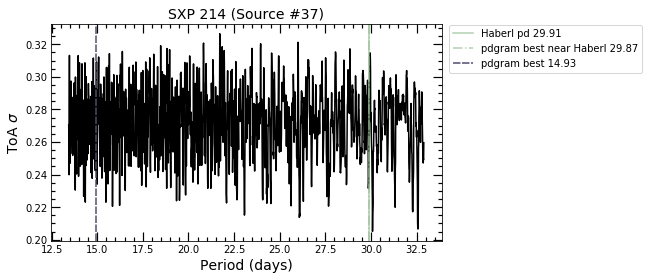

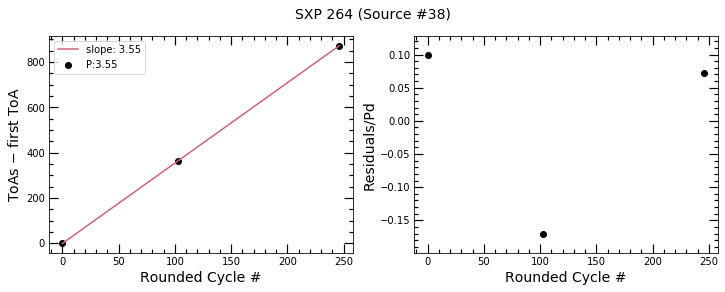

added 42 to xdict
added 42 to xdict
added 42 to xdict


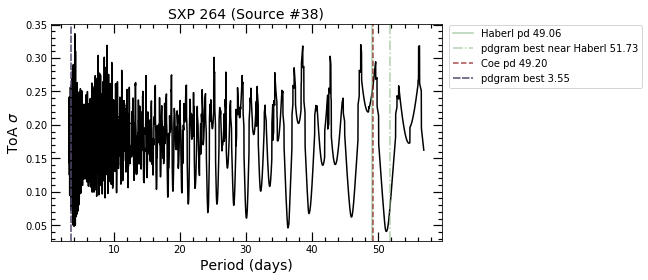

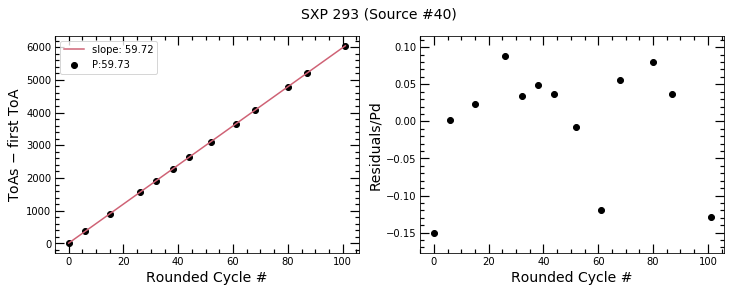

added 45 to xdict
added 45 to xdict
added 45 to xdict


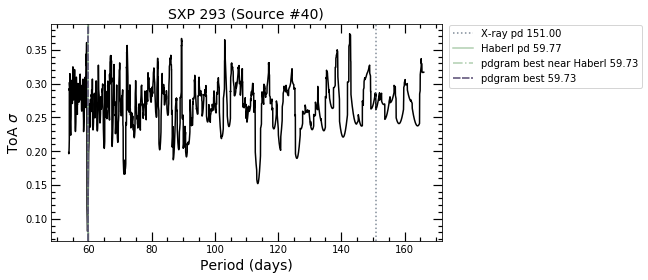

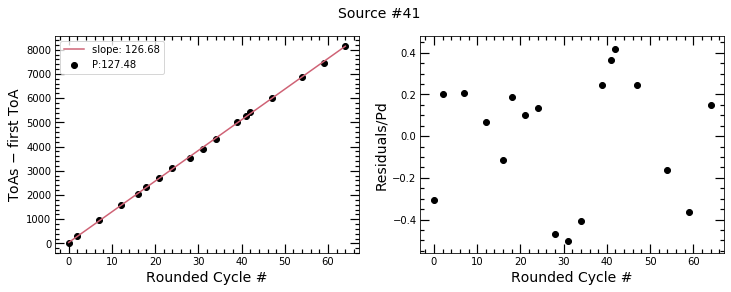

added 46 to xdict
added 46 to xdict
added 46 to xdict


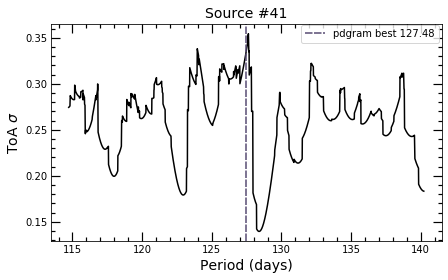

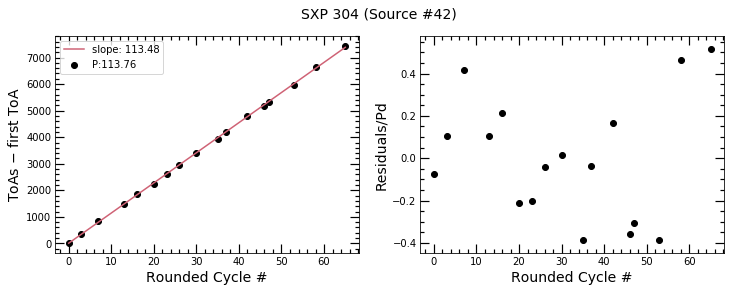

added 47 to xdict
added 47 to xdict
added 47 to xdict


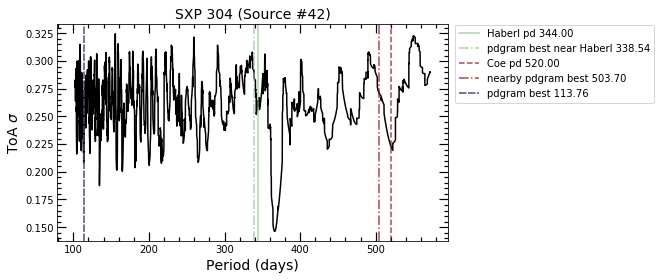

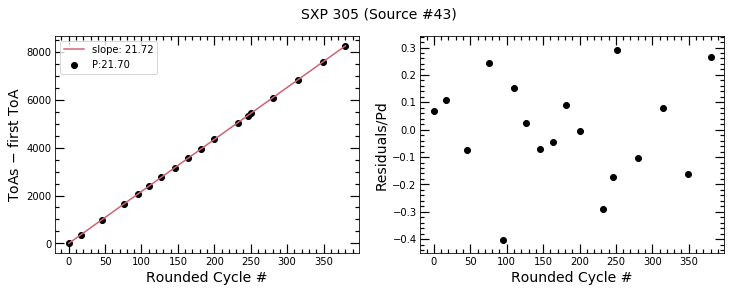

added 48 to xdict
added 48 to xdict
added 48 to xdict


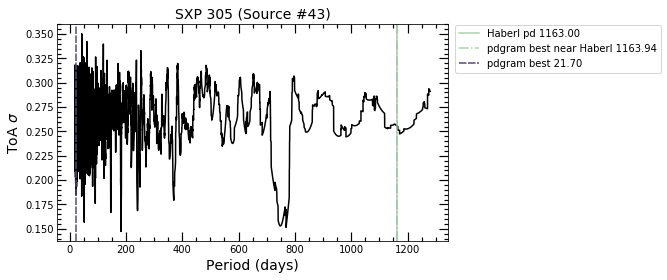

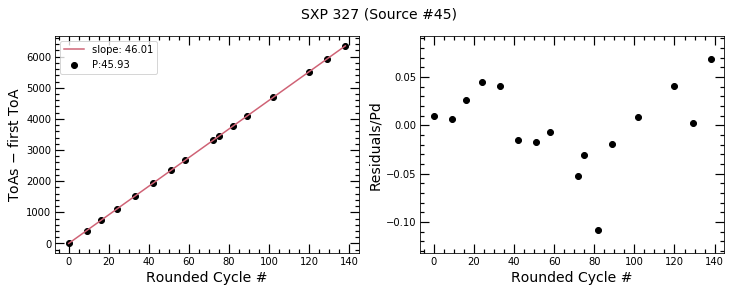

added 50 to xdict
added 50 to xdict
added 50 to xdict


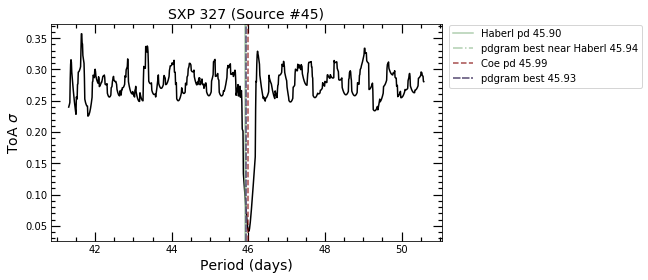

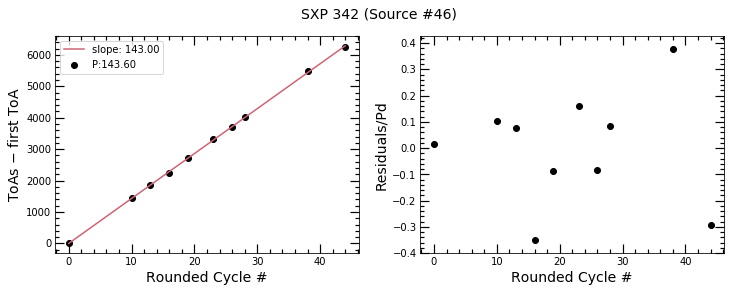

added 51 to xdict
added 51 to xdict
added 51 to xdict


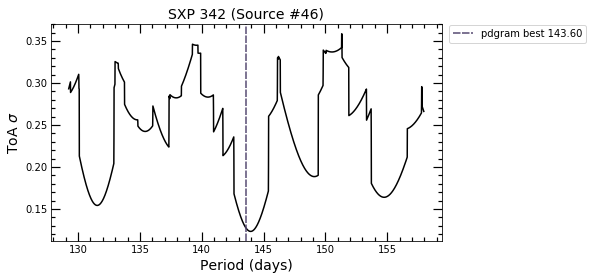

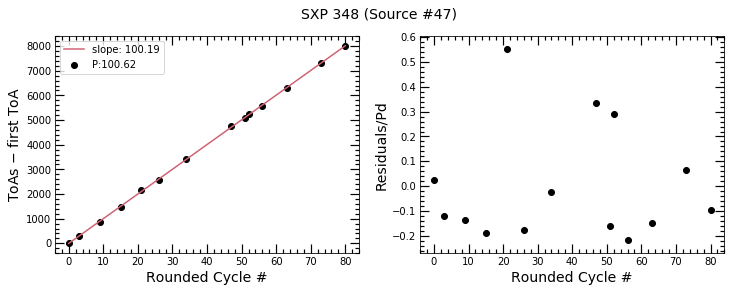

added 52 to xdict
added 52 to xdict
added 52 to xdict


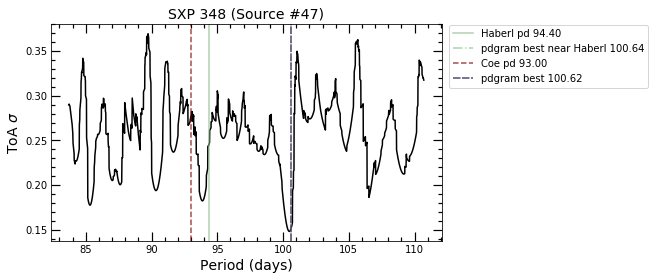

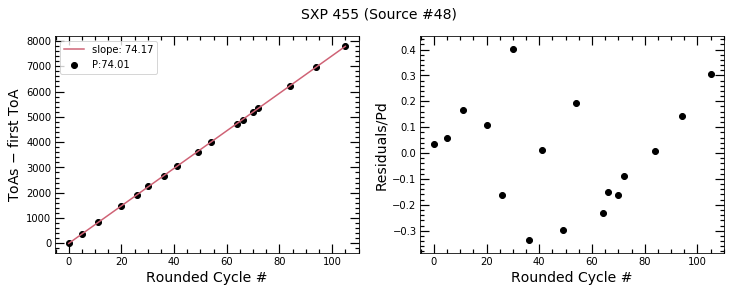

added 53 to xdict
added 53 to xdict
added 53 to xdict


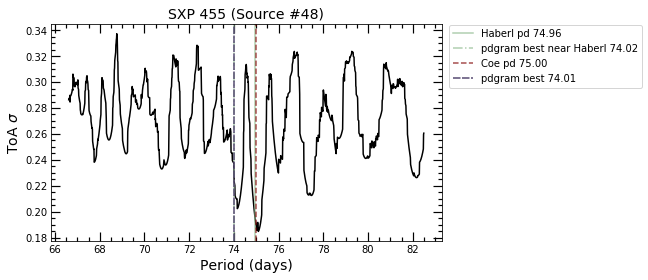

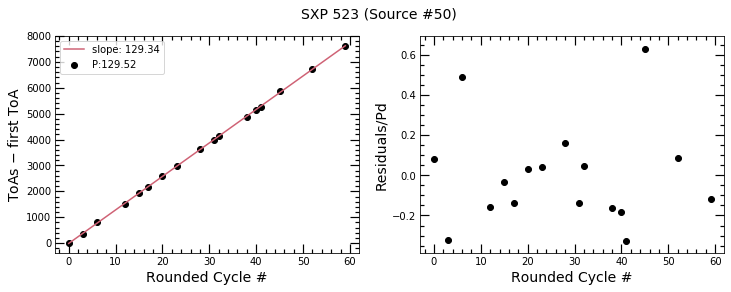

added 55 to xdict
added 55 to xdict
added 55 to xdict


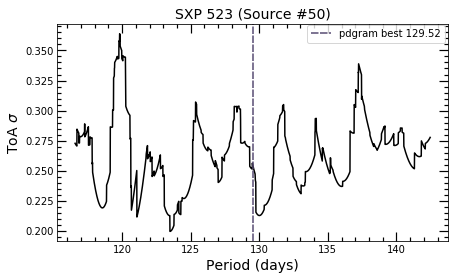

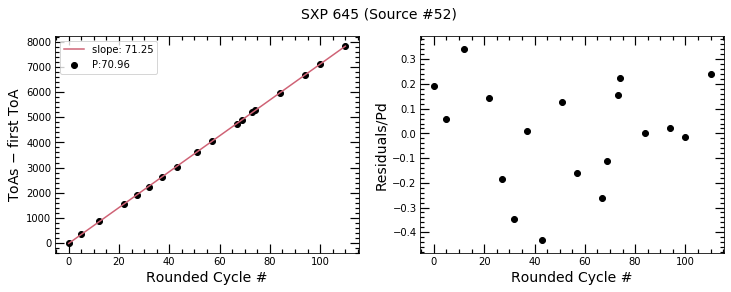

added 57 to xdict
added 57 to xdict
added 57 to xdict


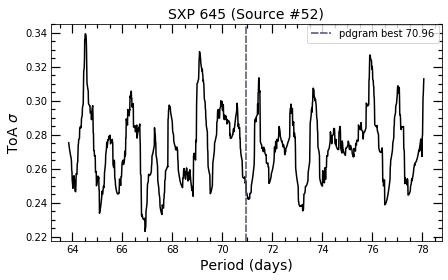

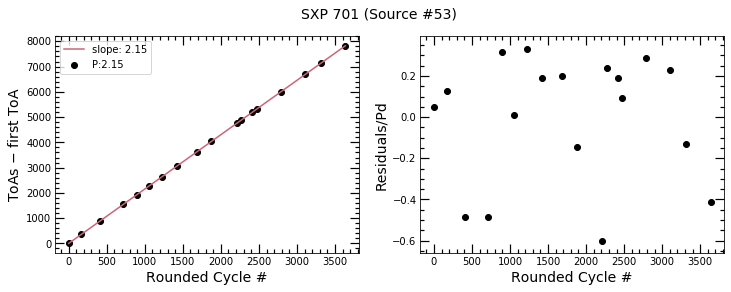

added 58 to xdict
added 58 to xdict
added 58 to xdict


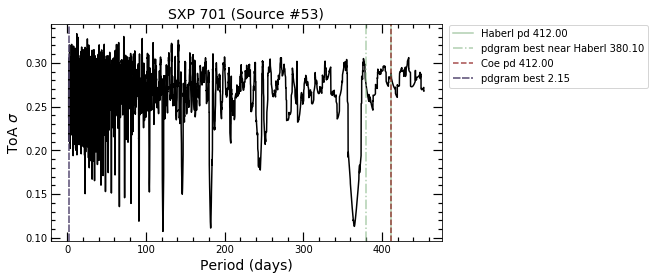

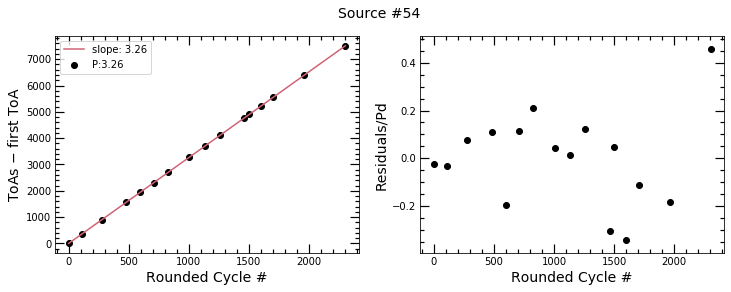

added 59 to xdict
added 59 to xdict
added 59 to xdict


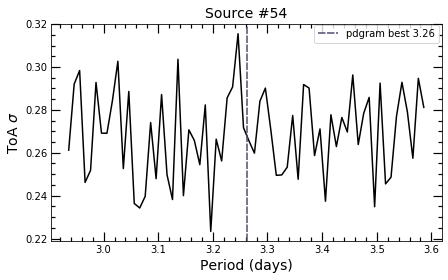

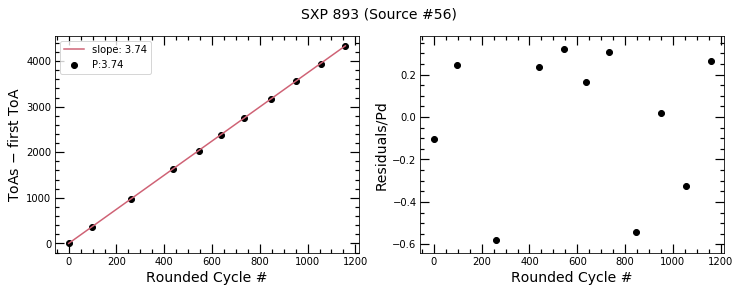

added 61 to xdict
added 61 to xdict
added 61 to xdict


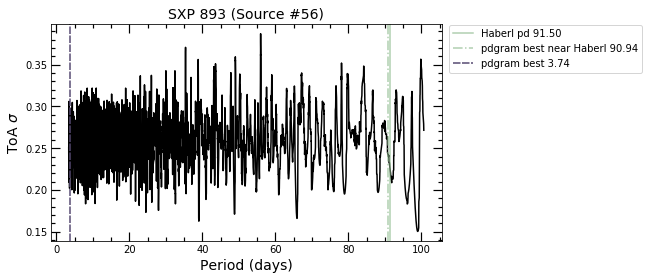

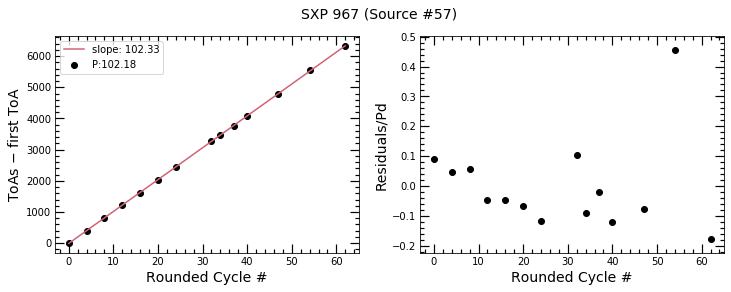

added 62 to xdict
added 62 to xdict
added 62 to xdict


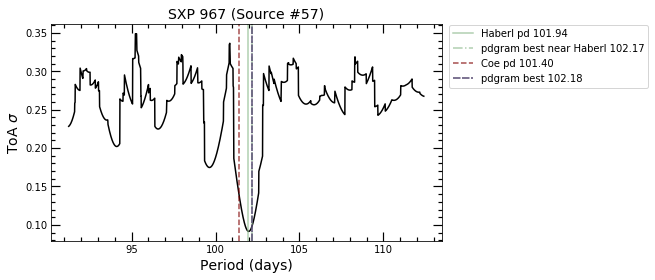

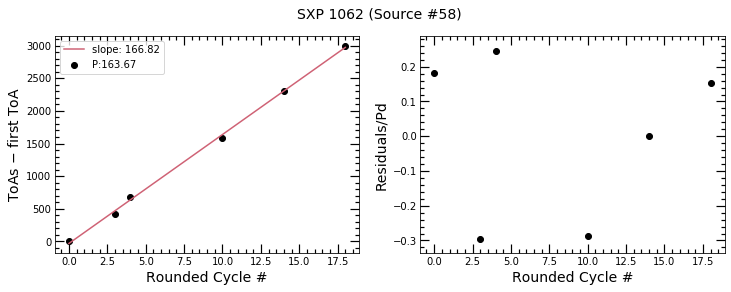

added 63 to xdict
added 63 to xdict
added 63 to xdict


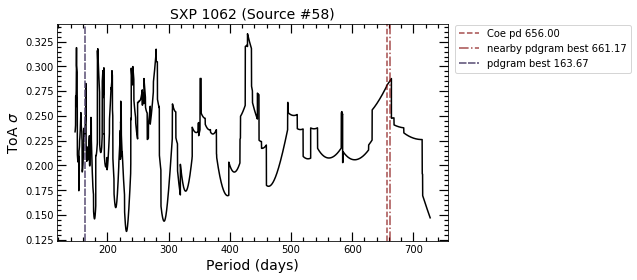

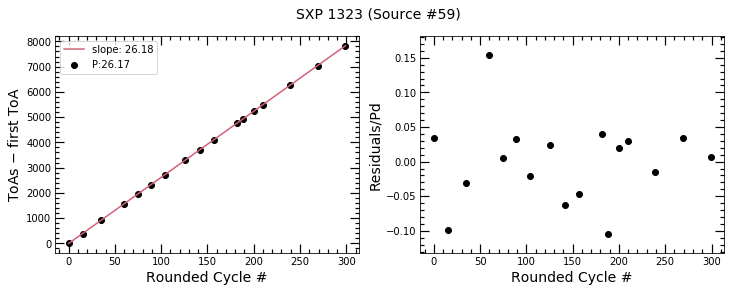

added 64 to xdict
added 64 to xdict
added 64 to xdict


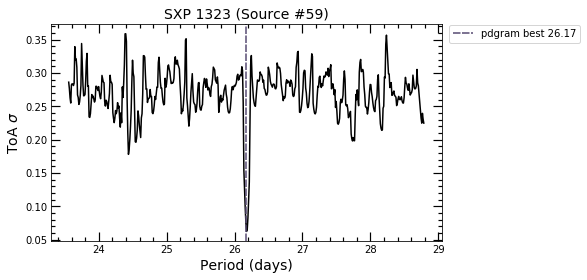

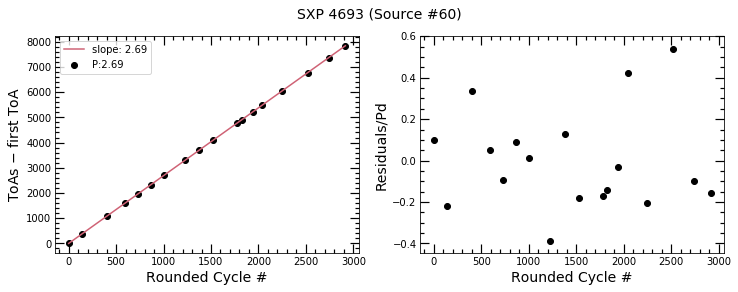

added 65 to xdict
added 65 to xdict
added 65 to xdict


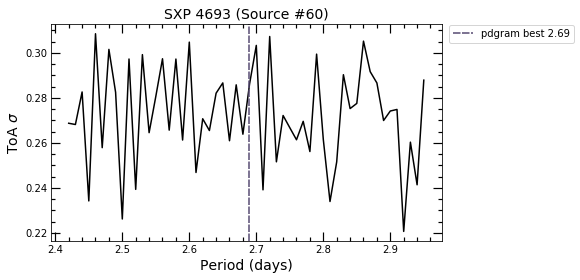

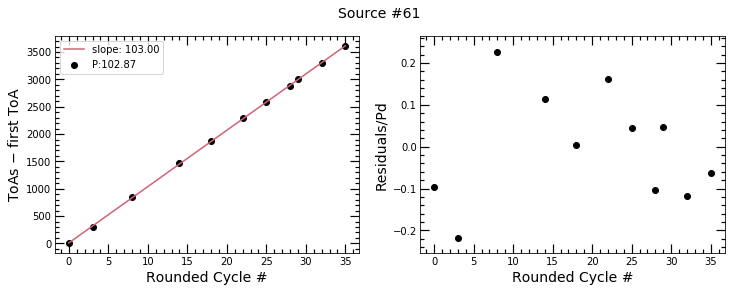

added 67 to xdict
added 67 to xdict
added 67 to xdict


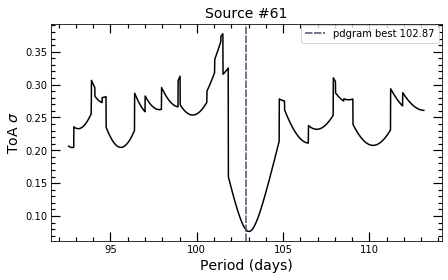

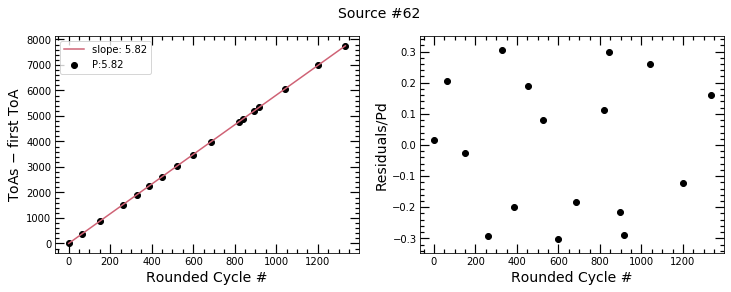

added 68 to xdict
added 68 to xdict
added 68 to xdict


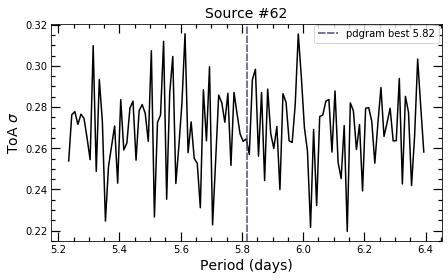

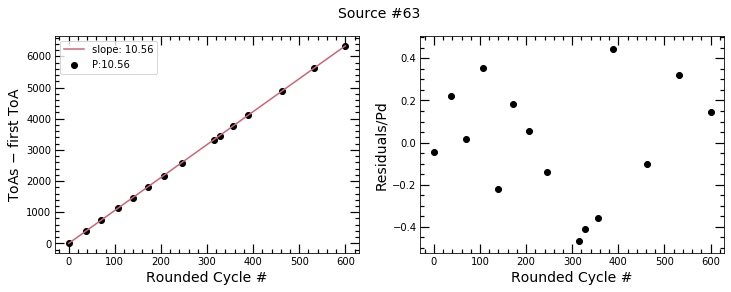

added 69 to xdict
added 69 to xdict
added 69 to xdict


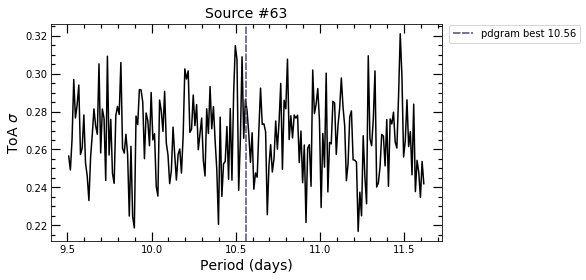

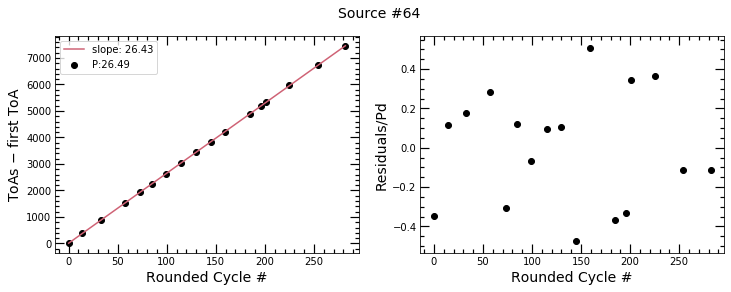

added 71 to xdict
added 71 to xdict
added 71 to xdict


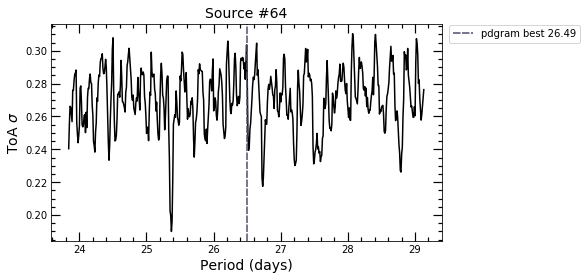

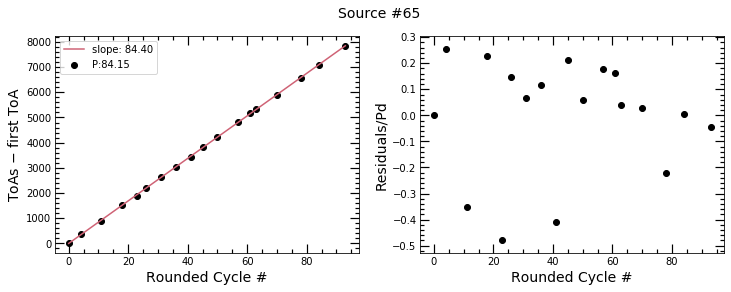

added 72 to xdict
added 72 to xdict
added 72 to xdict


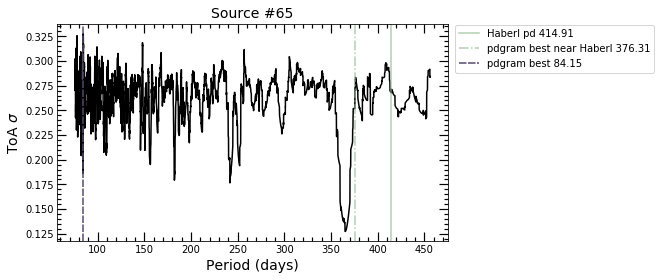

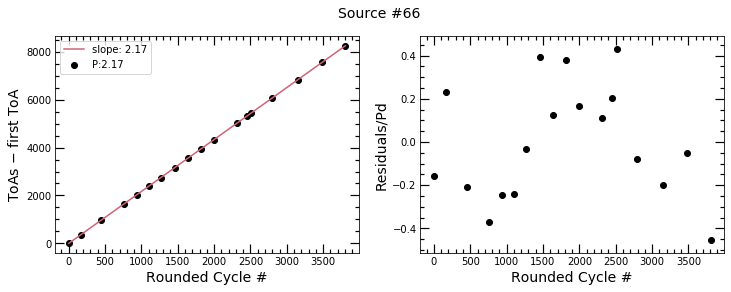

added 73 to xdict
added 73 to xdict
added 73 to xdict


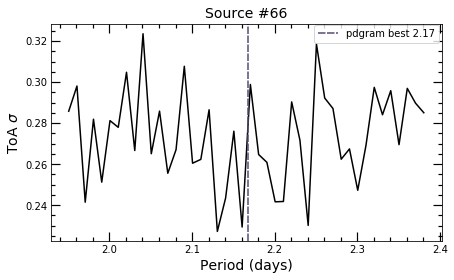

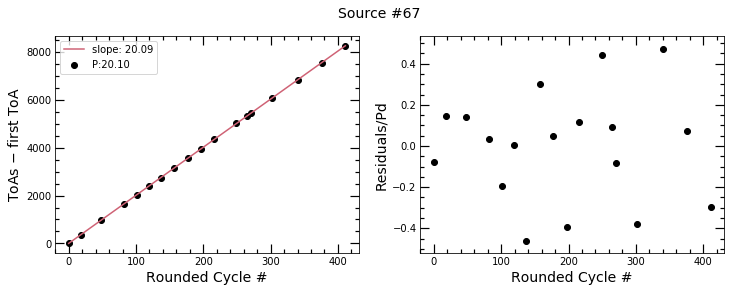

added 75 to xdict
added 75 to xdict
added 75 to xdict


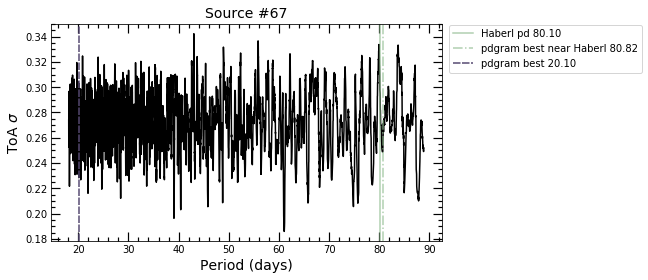

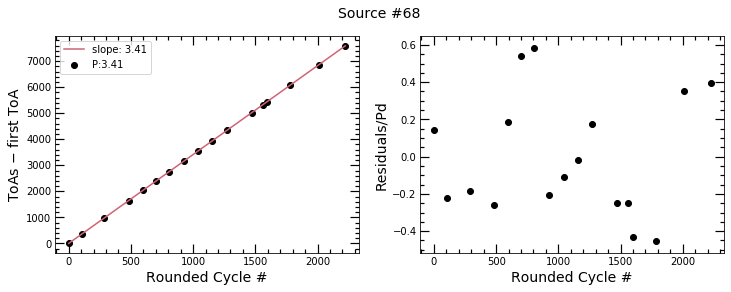

added 76 to xdict
added 76 to xdict
added 76 to xdict


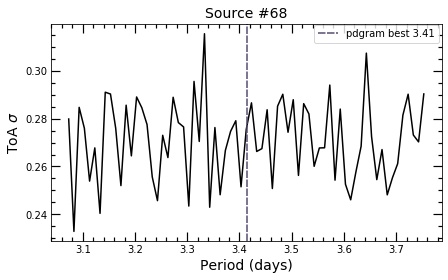

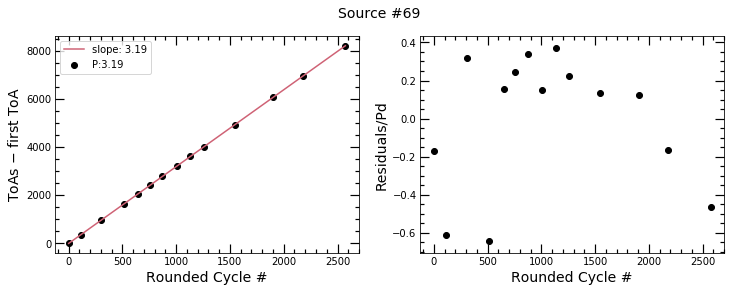

added 77 to xdict
added 77 to xdict
added 77 to xdict
empty file for OII I


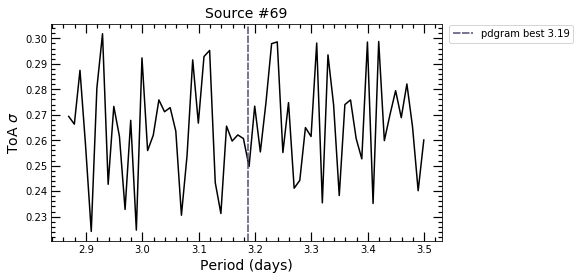

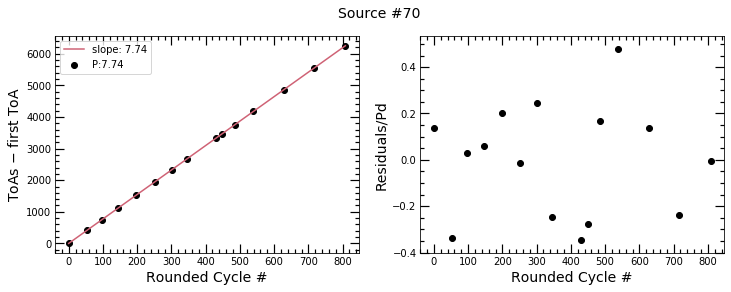

empty file for OII I
added 78 to xdict
empty file for OII I
added 78 to xdict
empty file for OII I
added 78 to xdict


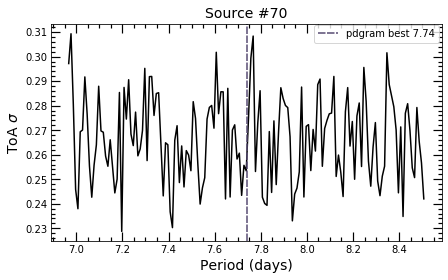

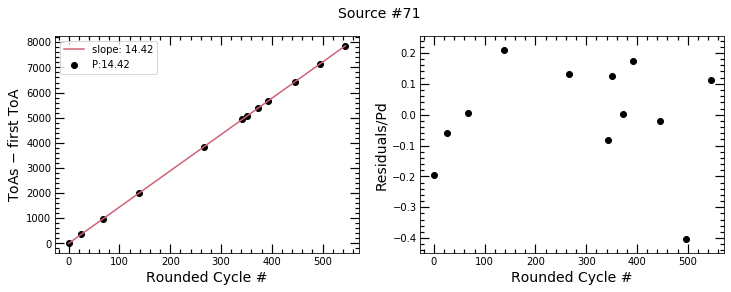

added 79 to xdict
added 79 to xdict
added 79 to xdict


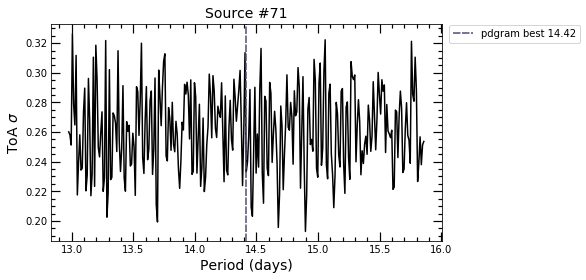

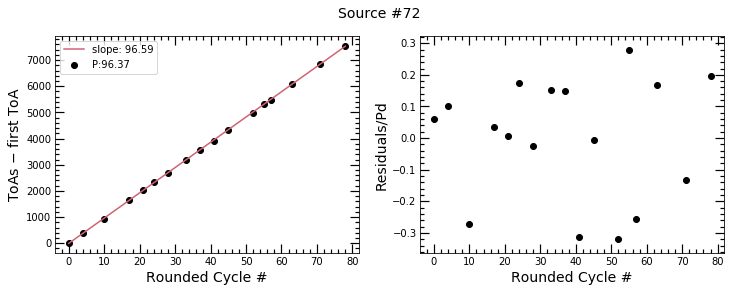

added 80 to xdict
added 80 to xdict
added 80 to xdict


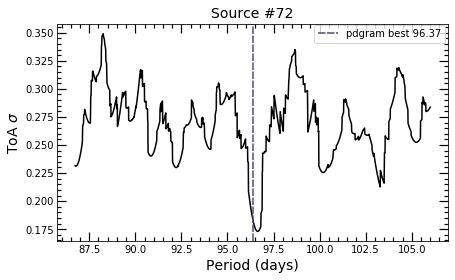

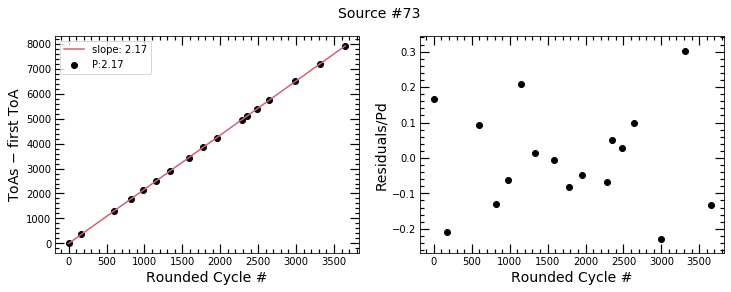

added 81 to xdict
added 81 to xdict
added 81 to xdict


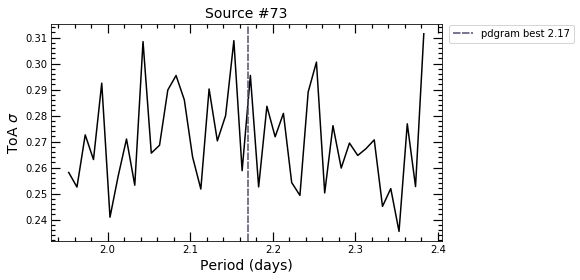

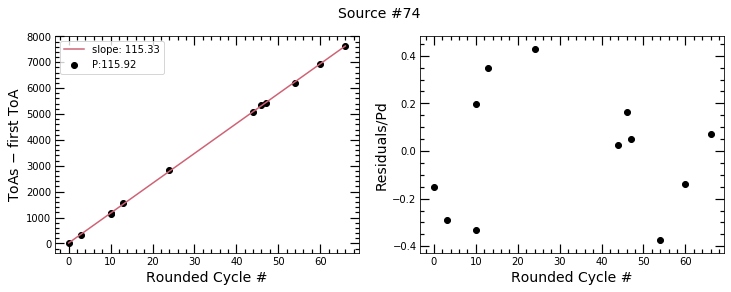

added 82 to xdict
added 82 to xdict
added 82 to xdict


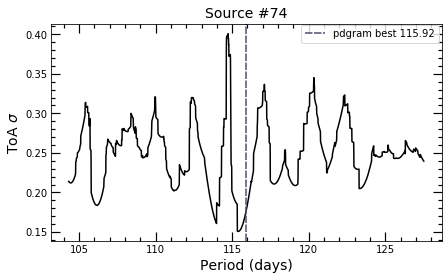

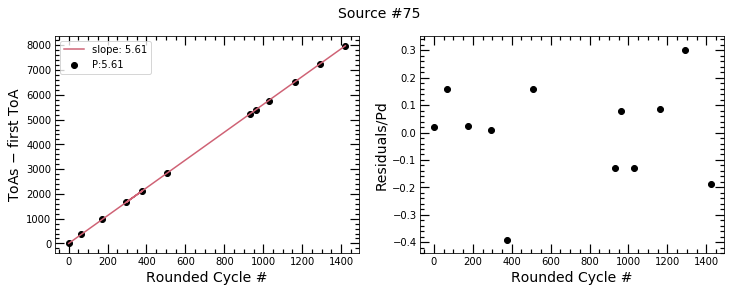

added 84 to xdict
added 84 to xdict
added 84 to xdict


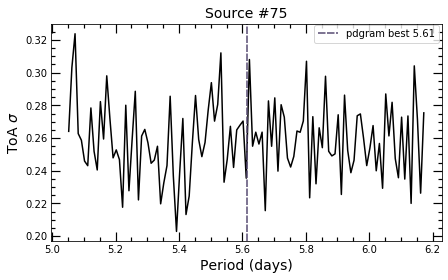

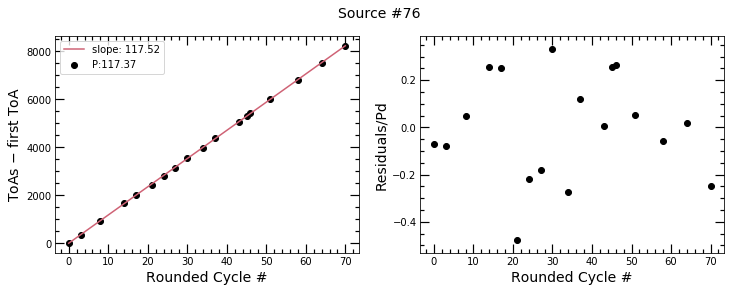

added 85 to xdict
added 85 to xdict
added 85 to xdict


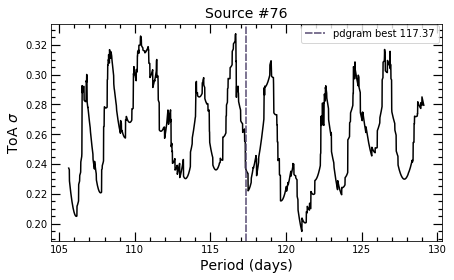

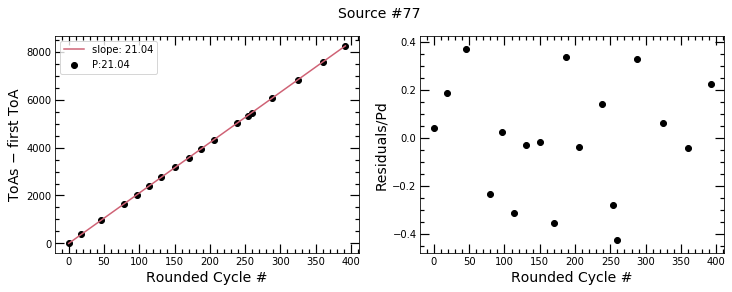

added 86 to xdict
added 86 to xdict
added 86 to xdict


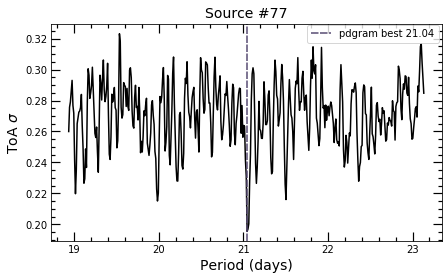

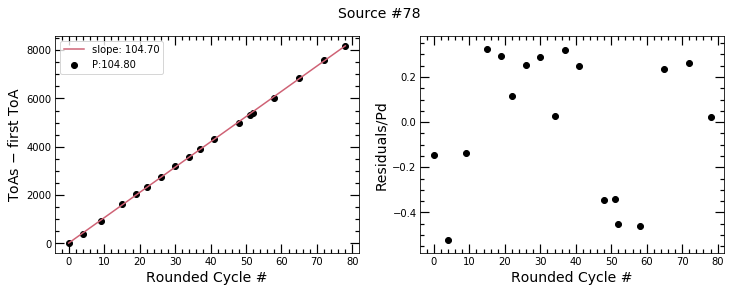

added 87 to xdict
added 87 to xdict
added 87 to xdict


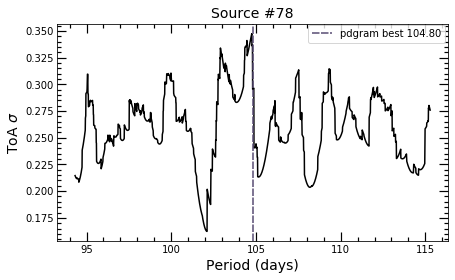

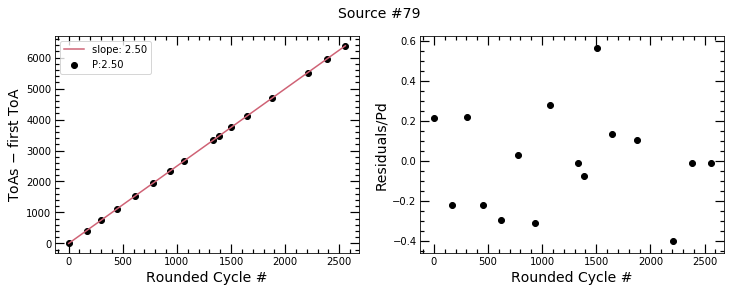

added 93 to xdict
added 93 to xdict
added 93 to xdict


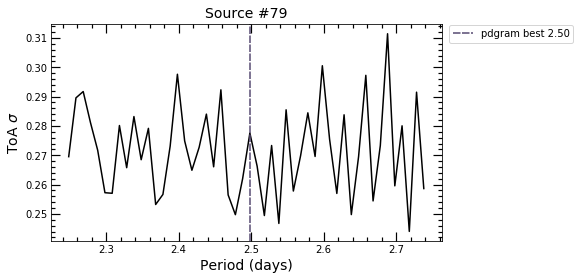

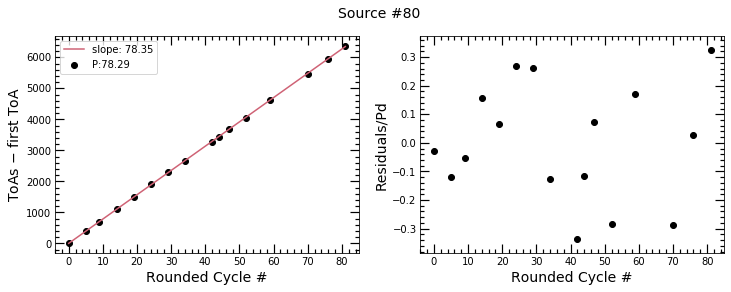

added 95 to xdict
added 95 to xdict
added 95 to xdict


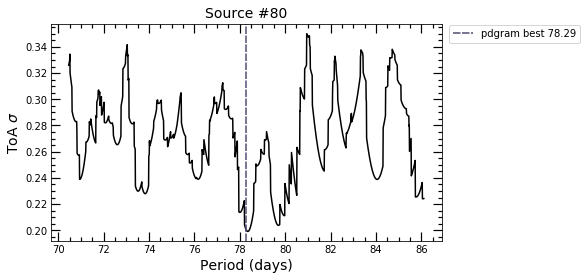

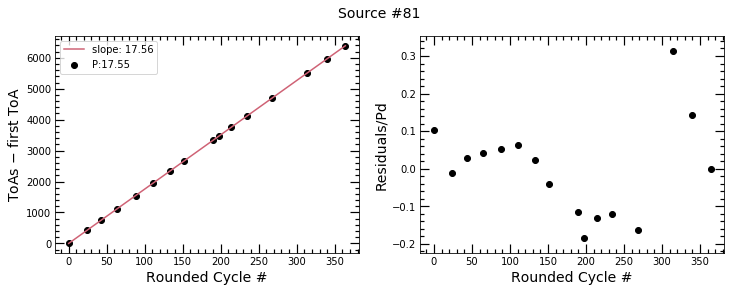

added 96 to xdict
added 96 to xdict
added 96 to xdict


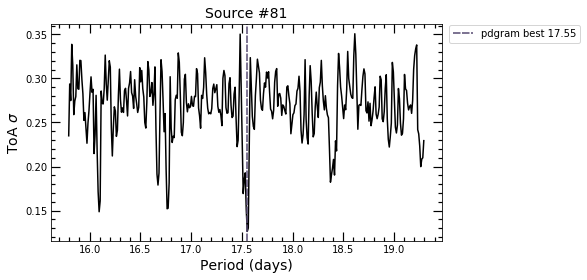

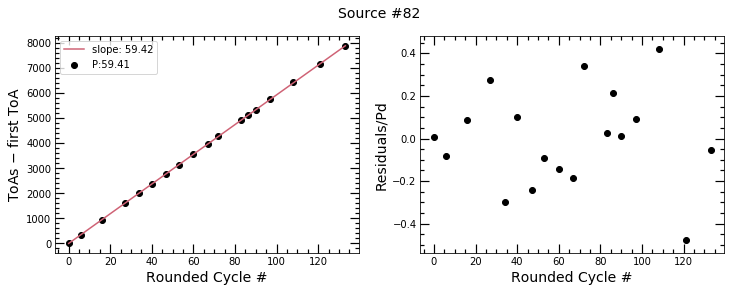

added 97 to xdict
added 97 to xdict
added 97 to xdict


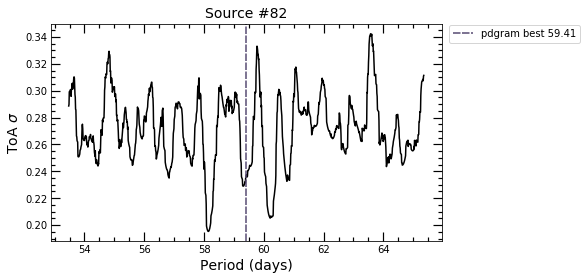

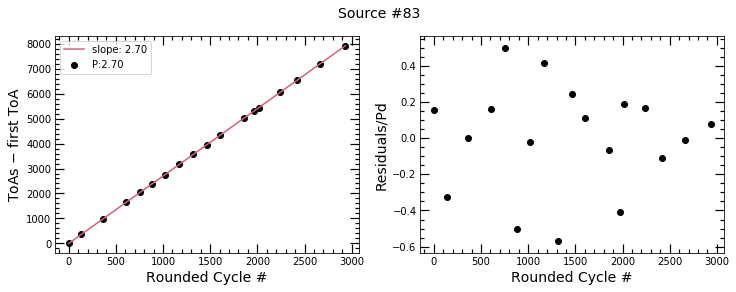

added 98 to xdict
added 98 to xdict
added 98 to xdict


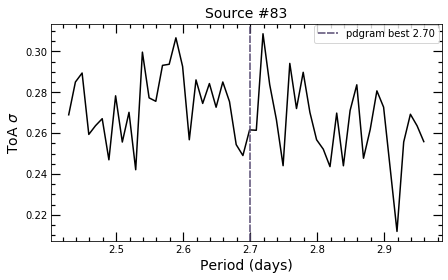

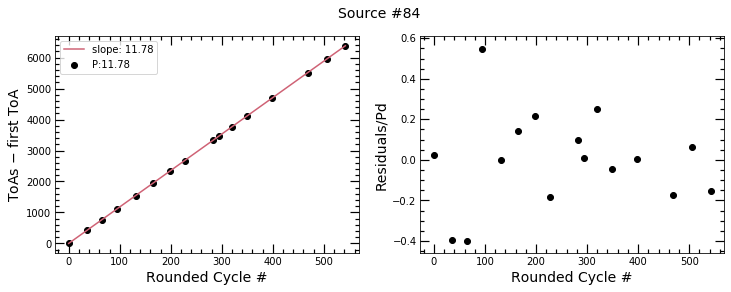

added 100 to xdict
added 100 to xdict
added 100 to xdict


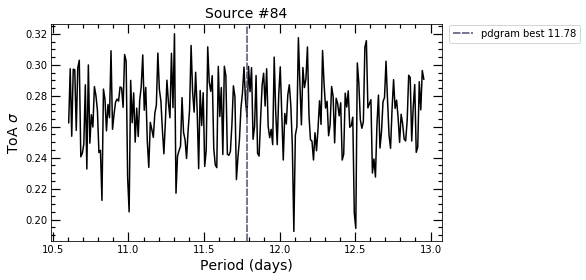

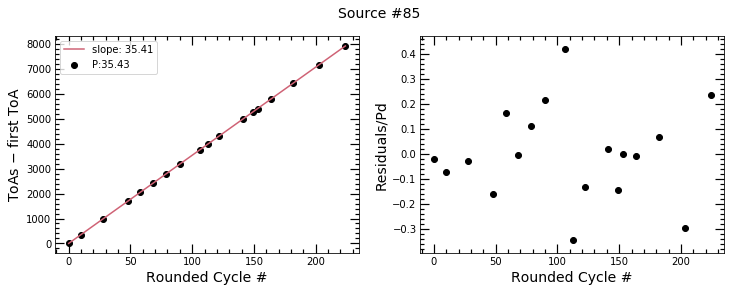

added 101 to xdict
added 101 to xdict
added 101 to xdict


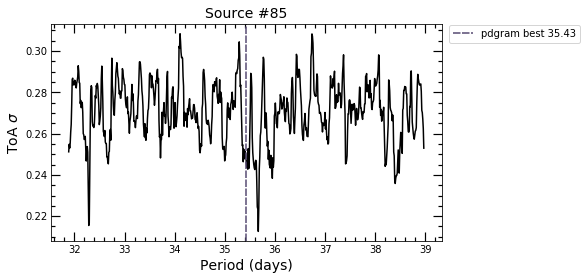

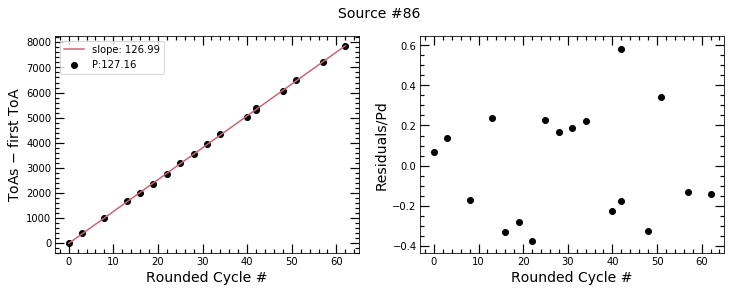

added 104 to xdict
added 104 to xdict
added 104 to xdict


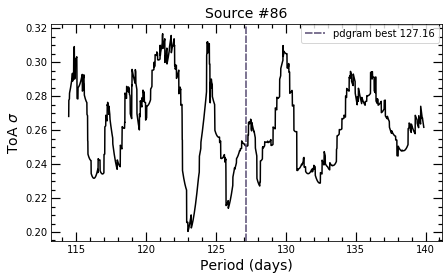

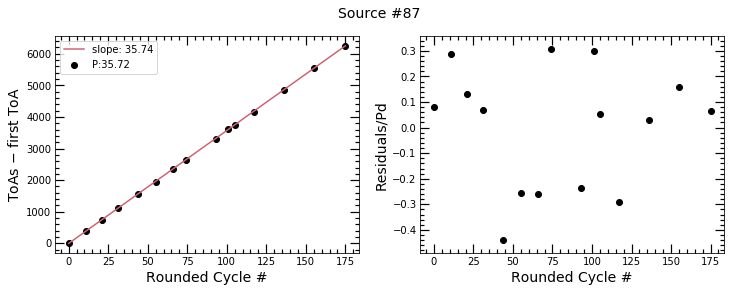

added 105 to xdict
added 105 to xdict
added 105 to xdict


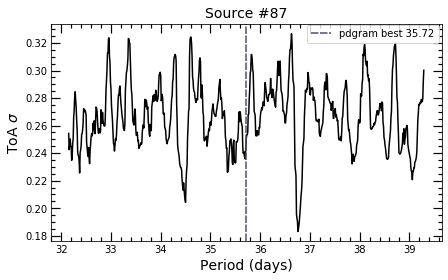

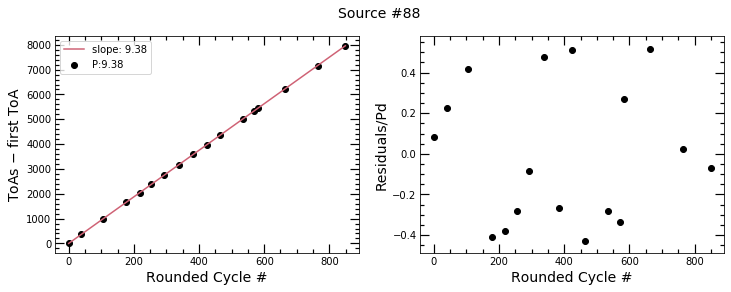

added 106 to xdict
added 106 to xdict
added 106 to xdict
empty file for OIII I


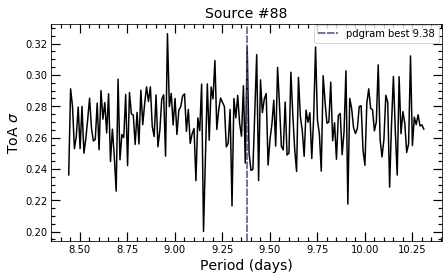

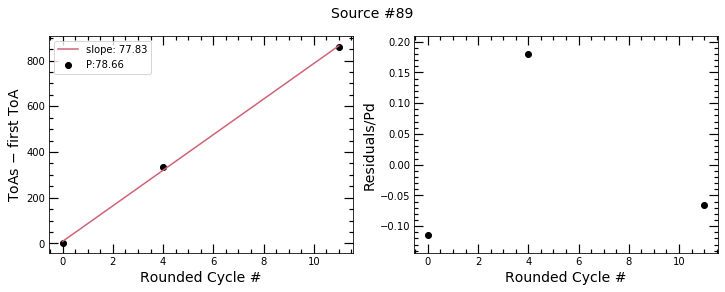

empty file for OIII I
added 107 to xdict
empty file for OIII I
added 107 to xdict
empty file for OIII I
added 107 to xdict


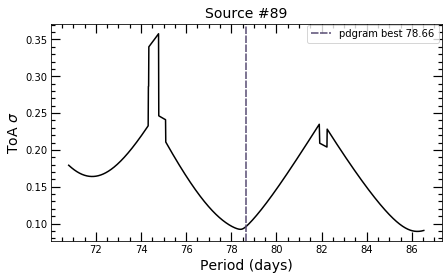

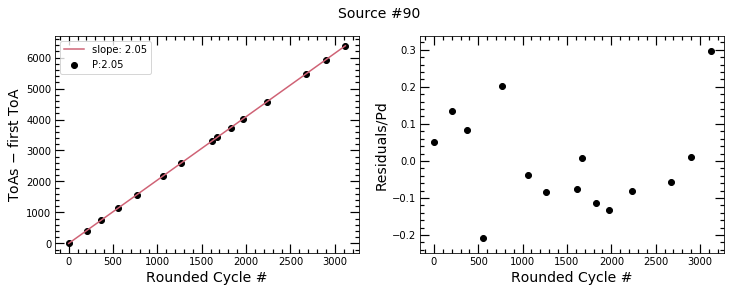

added 111 to xdict
added 111 to xdict
added 111 to xdict


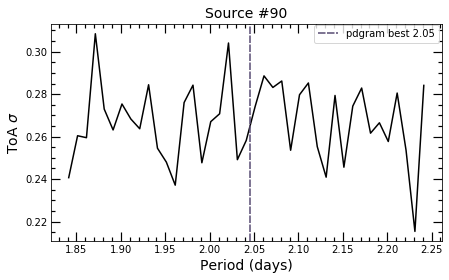

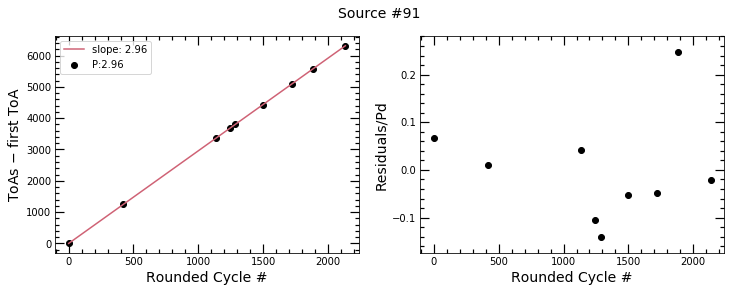

added 114 to xdict
added 114 to xdict
added 114 to xdict


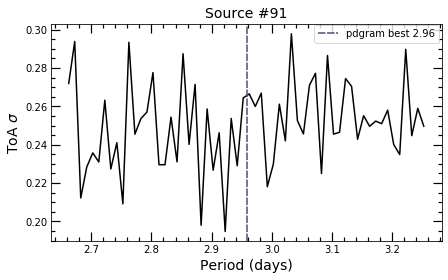

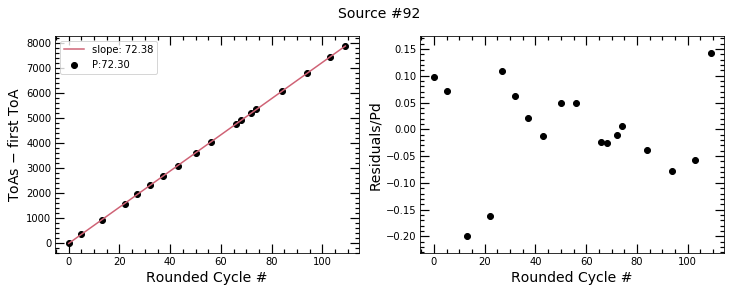

added 115 to xdict
added 115 to xdict
added 115 to xdict


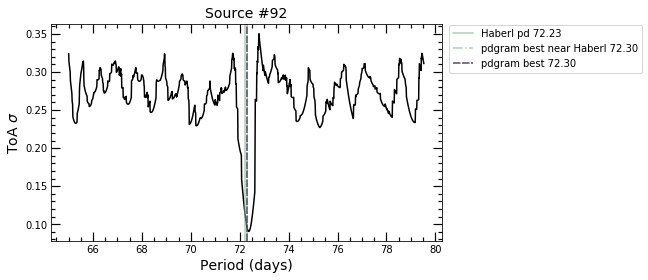

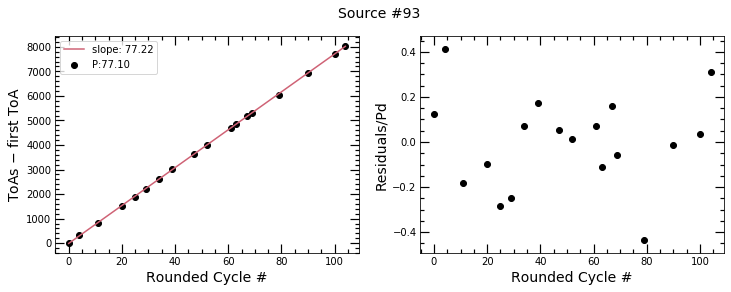

added 116 to xdict
added 116 to xdict
added 116 to xdict


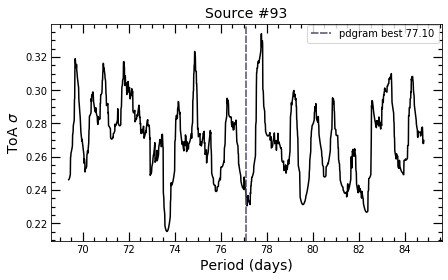

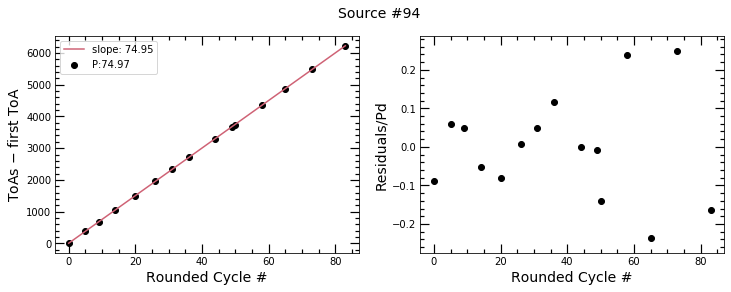

added 119 to xdict
added 119 to xdict
added 119 to xdict


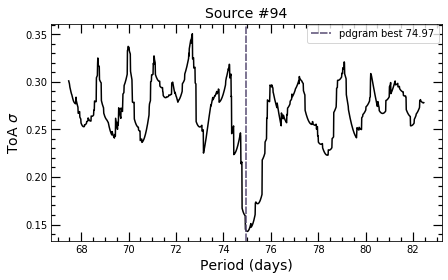

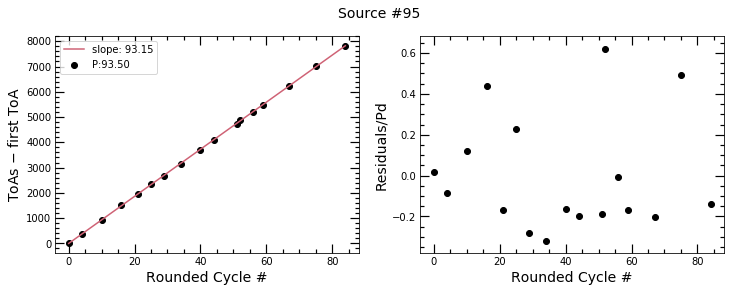

added 121 to xdict
added 121 to xdict
added 121 to xdict


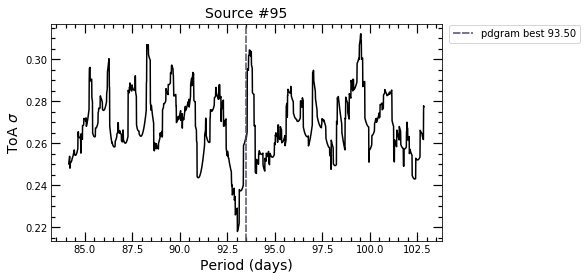

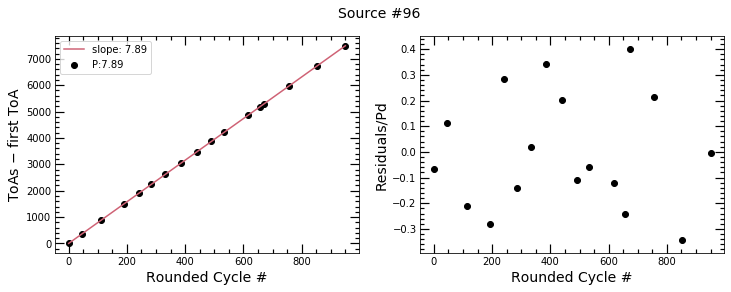

added 123 to xdict
added 123 to xdict
added 123 to xdict


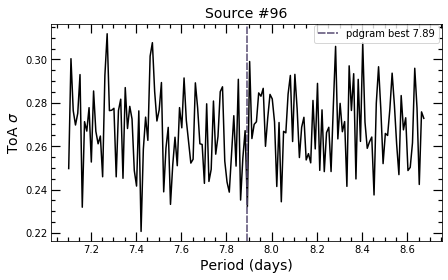

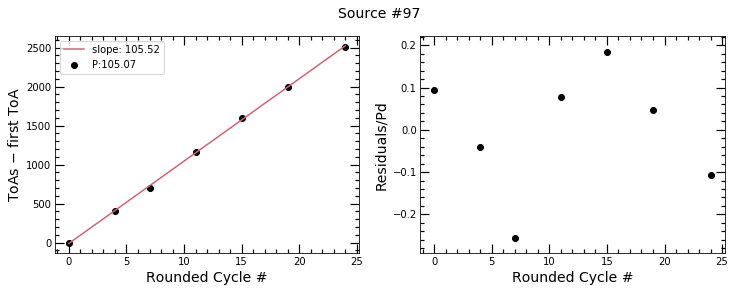

added 124 to xdict
added 124 to xdict
added 124 to xdict


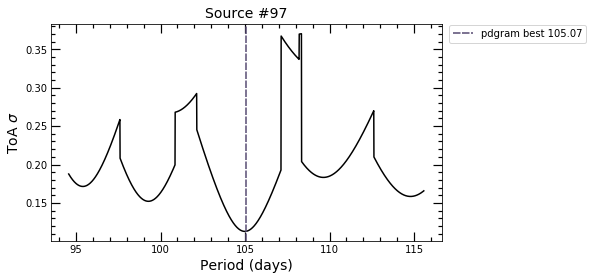

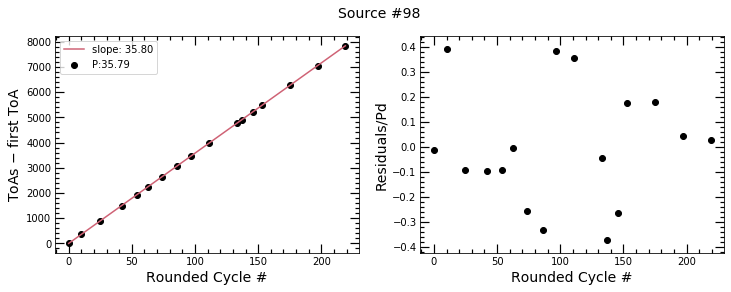

added 125 to xdict
added 125 to xdict
added 125 to xdict


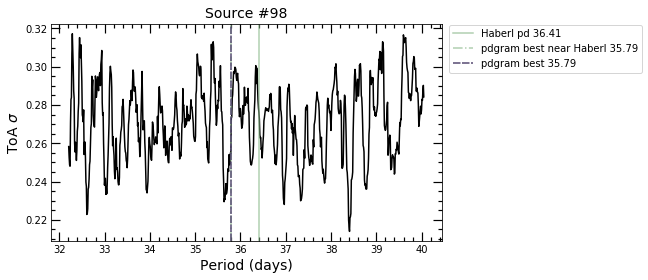

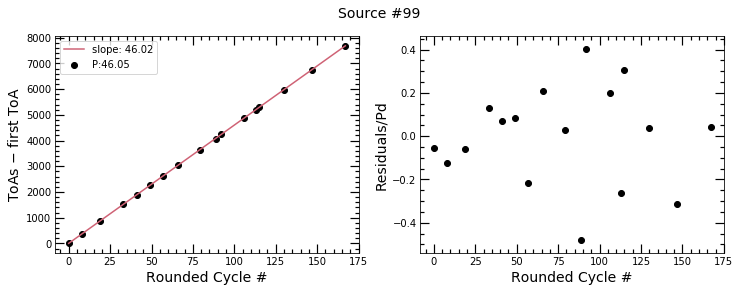

added 126 to xdict
added 126 to xdict
added 126 to xdict


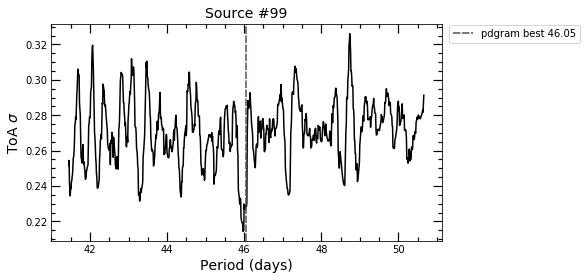

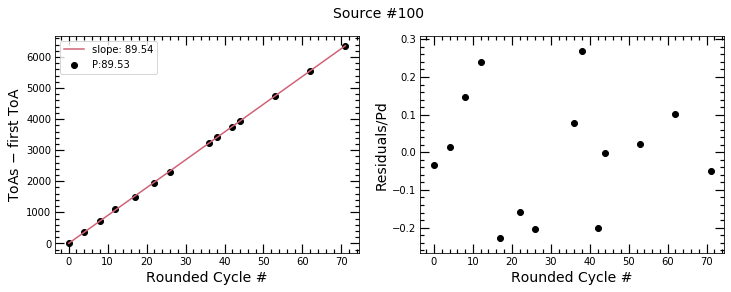

added 128 to xdict
added 128 to xdict
added 128 to xdict


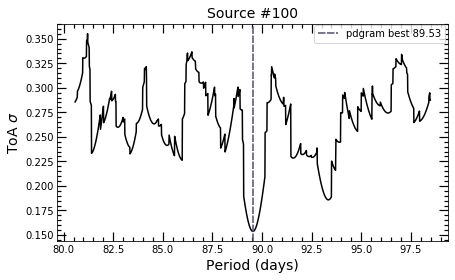

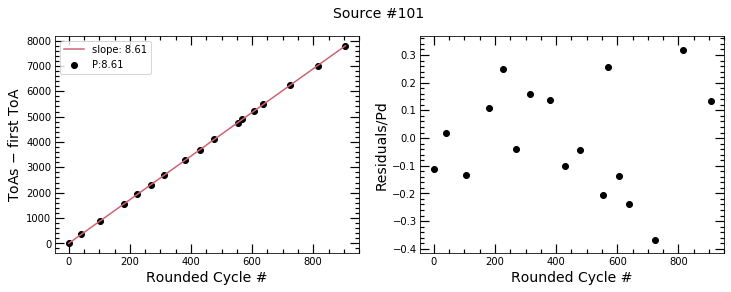

added 129 to xdict
added 129 to xdict
added 129 to xdict


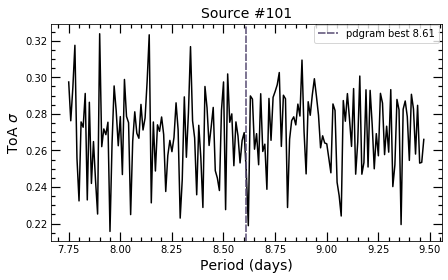

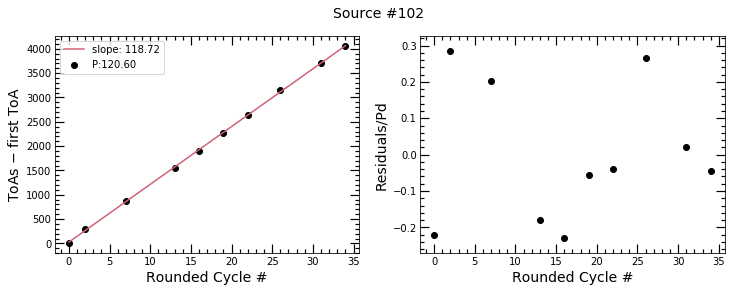

added 132 to xdict
added 132 to xdict
added 132 to xdict


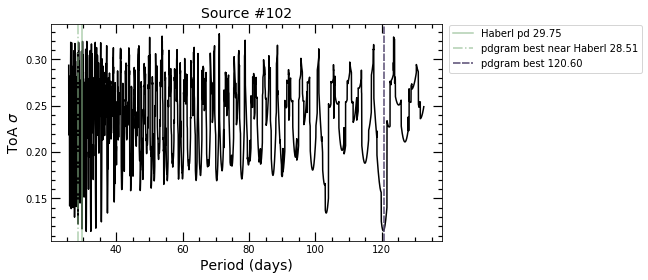

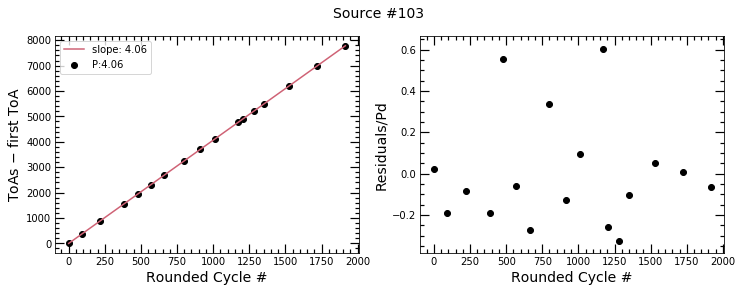

added 133 to xdict
added 133 to xdict
added 133 to xdict


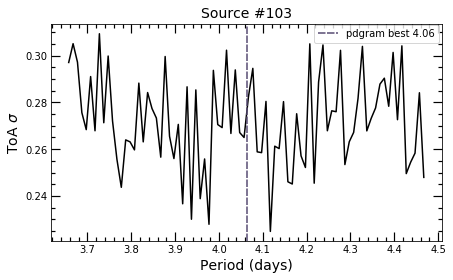

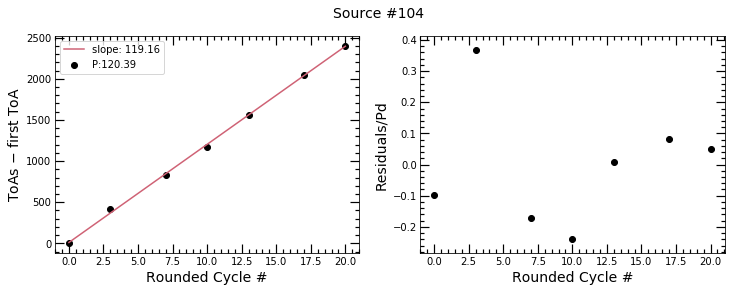

added 136 to xdict
added 136 to xdict
added 136 to xdict


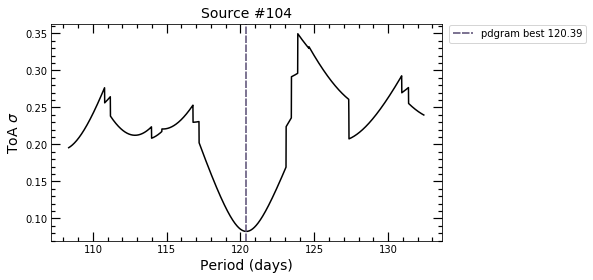

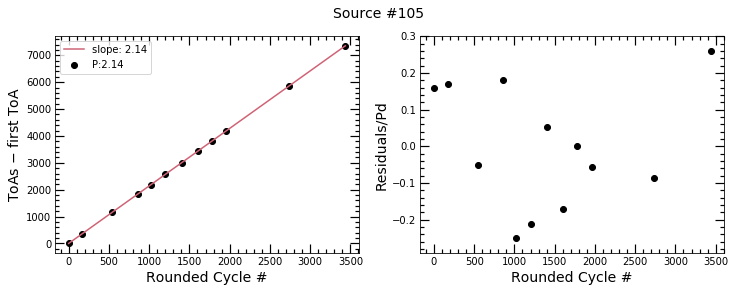

added 138 to xdict
added 138 to xdict
added 138 to xdict


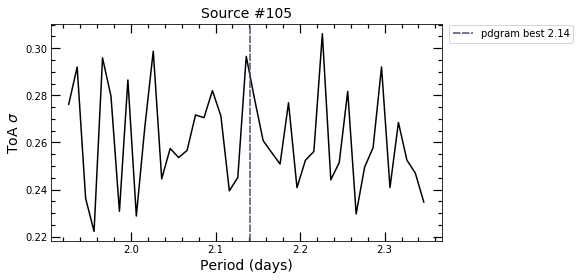

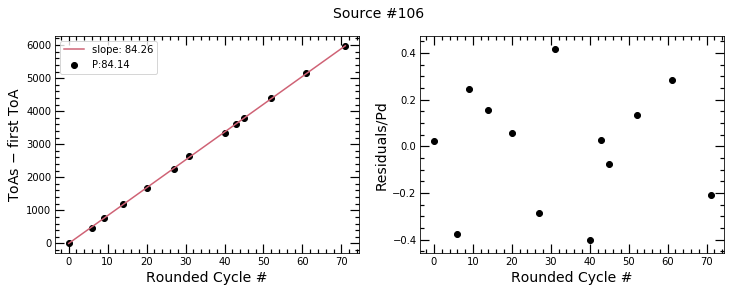

added 139 to xdict
added 139 to xdict
added 139 to xdict


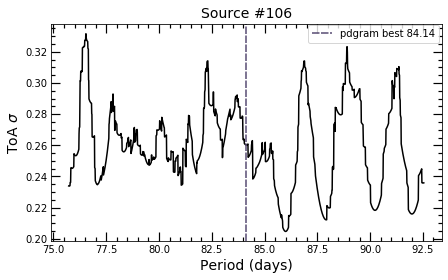

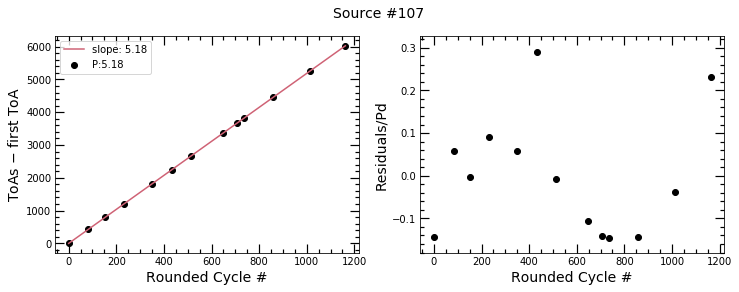

added 141 to xdict
added 141 to xdict
added 141 to xdict


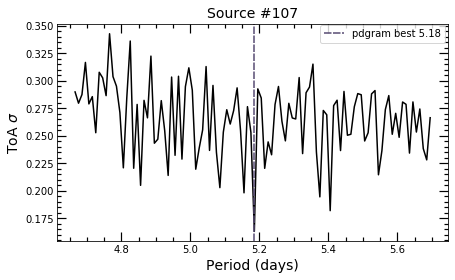

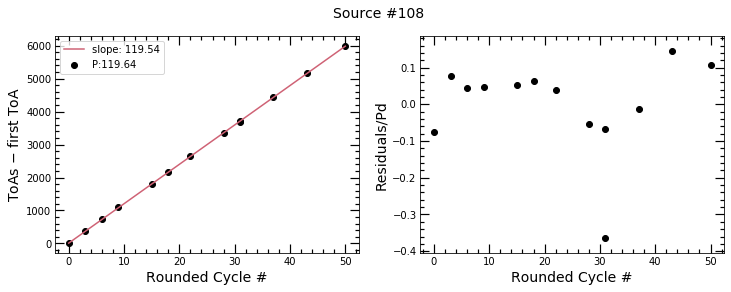

added 142 to xdict
added 142 to xdict
added 142 to xdict


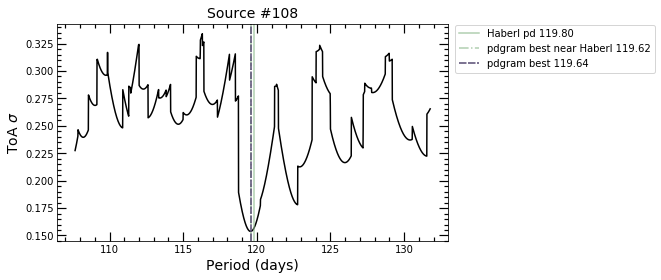

In [81]:
#again, loop through
srcs = np.array(summ['src_n'])
for i in range(len(srcs)):
    src = srcs[i]
    if src not in xlist: #only ones that haven't been run already
        #starts with best from 2-200d periodogram
        try:
            toas,pd = yearloop(src,0,findpd='best',retpd=True)
            res(toas,pd,src=src)
            iterate(src)
        except:
            print(f'{src} not working...')